In [ ]:
import re
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv
from prettytable import PrettyTable
from sklearn.utils import shuffle
!pip install sumeval
from sumeval.metrics.rouge import RougeCalculator

BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50 # first it was 200

     |████████████████████████████████| 80 kB 3.2 MB/s 
     |████████████████████████████████| 90 kB 6.5 MB/s 
  Created wheel for sumeval: filename=sumeval-0.2.2-py3-none-any.whl size=54549 sha256=17876244edc319581955e49a935ffc5c5b8036e6fe02ecbadba9a34f5168915c
  Stored in directory: /root/.cache/pip/wheels/f4/3f/31/c521bdfba2be7518bd94ba3e8b982812822167cc0497fad192
Successfully built sumeval


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
data_unprocessed_news = pd.read_excel('/content/drive/MyDrive/Tranformers/data.xlsx')
data_unprocessed_news.head(3)

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25


In [ ]:
# shuffling the data 
data_unprocessed_news = shuffle(data_unprocessed_news)
data_unprocessed_news.head(3)

,Headline,Short,Source,Time,Publish Date
45217,IS leader killed in strike in Iraq: Pentagon,A US-led air strike has killed Islamic State l...,Reuters,17:23:00,2016-05-10
29213,Super Glue was rejected because it stuck to ev...,The strong and fast-acting adhesive used to ma...,Super Glue,19:23:00,2016-09-22
48826,Instagram increases video length limit to 60 sec,Instagram on Tuesday announced that it is incr...,The Verge,05:56:00,2016-03-30


In [ ]:
def partition_data(data):
    summaries = pd.DataFrame()
    summaries['short']=data['Headline']
    longreview = pd.DataFrame()
    longreview['long'] = data['Short']
    return summaries, longreview
    
summaries, longreview = partition_data(data_unprocessed_news)


In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Data", "size"]
x.add_row(["longreview", longreview.shape])
x.add_row(["short", summaries.shape])
print(x)

+------------+------------+
|    Data    |    size    |
+------------+------------+
| longreview | (55104, 1) |
|   short    | (55104, 1) |
+------------+------------+


In [ ]:
PATTERNS = {r"http\S+":"",
            r"there's":"there is",
            r"i'm": "i am",
            r"he's":"he is",
            r"she's":"she is",
            r"it's":"it is",
            r"that's":"that is",
            r"what's": "what is",
            r"where's": "where is",
            r"how's": "how is",
            r"\'ll":" will",
            r"\'ve": " have",
            r"\'re": " are",
            r"\'d":" would",
            r"\'re": " are",
            r"won't": "will not",
            r"can't": "cannot",
            r"n't": " not",
            r"n'":"ng",
            r"'bout": "about",
            r"'til": "until",
            r"\"": "",
            r"\'": "",
            r' s ': "",
            r"&39": "",
            r"&34": "",
            r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]": "",
            r"&": "",
            r"\\n":""}

def remove_accented_chars(sentence):
    strng = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    return strng

def clean_words(sentence, patterns = PATTERNS):
    # replacing many abbreviations and lower casing the words
    sentence = str(sentence).lower()
    sentence = remove_accented_chars(sentence)
   

    for substr, substitute in patterns.items():
        sentence = re.sub(substr, substitute, sentence)
    sentence = sentence.strip()
    return sentence

# replacing many abbreviations and lower casing the words


In [ ]:
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))

In [ ]:
longreview.head()

,long
45217,a usled air strike has killed islamic state le...
29213,the strong and fastacting adhesive used to mak...
48826,instagram on tuesday announced that it is incr...
22515,ukrainian firm limpid armor has developed holo...
49312,the government on wednesday approved billion ...


In [ ]:
# adding start and end token to the senteces of label 
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

,short
45217,<startseq> is leader killed in strike in iraq ...
29213,<startseq> super glue was rejected because it ...
48826,<startseq> instagram increases video length li...
22515,<startseq> hololensequipped mixed reality mili...
49312,<startseq> world bank to extend cr to swachh ...


In [ ]:
def split_data(split_ratio, data):
    data_train = data[int(len(data)*split_ratio):]
    data_val = data[:int(len(data)*split_ratio)]
    return data_train, data_val

split_ratio = 0.1
summaries_train, summaries_val = split_data(split_ratio,summaries )
longreview_train, longreview_val = split_data(split_ratio, longreview)
len(longreview_val),len(longreview_train)

(5510, 49594)

In [ ]:
longreview_train.iloc[0], summaries_train.iloc[0]

(long    australian tennis player bernard tomic was fin...
 Name: 31932, dtype: object,
 short    <startseq> us open player fined k for abusing ...
 Name: 31932, dtype: object)

In [ ]:
# because there are senteces with unusually long lengths, 
# we caculate the max length that 95% of sentences are shorter than that
def max_length(shorts, longs, prct):
    # Create a list of all the captions
    
    length_longs = list(len(d.split()) for d in longs.to_list())
    length_shorts = list(len(d.split()) for d in shorts.to_list())

    x = PrettyTable()
    x.field_names = ["Percentile", "Max Length"]
    x.add_row([prct,str(np.percentile(length_longs, prct)) + " (Summaries)"])
    x.add_row([prct,str(np.percentile(length_shorts, prct)) + " (Length)"])
    print(x)
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_len_news, max_len_summary= max_length(summaries_train['short'], longreview_train['long'], 90)


print('Max-length longreview chosen for training: ', max_len_news)
print('Max-length summaries chosen for training: ', max_len_summary)

+------------+------------------+
| Percentile |    Max Length    |
+------------+------------------+
|     90     | 60.0 (Summaries) |
|     90     |  12.0 (Length)   |
+------------+------------------+
Max-length longreview chosen for training:  60
Max-length summaries chosen for training:  12


In [ ]:
from collections import defaultdict
# making a vocabulary of the words 
def create_vocab(shorts, longs = None, minimum_repeat = 3):

    # Create a list of all the captions
    all_captions = [s for s in shorts]
    # Consider only words which occur at least minimum_occurrence times in the corpus
    word_counts = defaultdict(int)
    for sent in all_captions:
        for w in sent.split(' '):
            word_counts[w] +=1

    return list(set([k for (k,v) in word_counts.items() if v >=minimum_repeat]))


In [ ]:
allow = set()
allow.add('a')
allow.add('i')

vocab_dec = create_vocab(summaries_train['short'].to_list(), minimum_repeat=5)
vocab_dec = list(filter(lambda v: len(v)>1 or v in allow, vocab_dec))  
vocab_dec = sorted(vocab_dec) # [1:] is for the '' 
vocab_dec[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aam',
 'aamir',
 'aamirs',
 'aap']

In [ ]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_enc = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
vocab_enc = list(filter(lambda v: len(v)>1 or (len(v)==1 and  v in allow), vocab_enc))  
vocab_enc = sorted(vocab_enc)
# vocab_enc = sorted(vocab_enc)[1:] # [1:] is for the '' 
vocab_enc[:10]


['****ing',
 'a',
 'a**holes',
 'aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhaarbased',
 'aadhaarenabled',
 'aadhaarlinked']

In [ ]:
len(vocab_dec), len(vocab_enc)

(8919, 32497)

In [ ]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
document_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)

document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)#summaries_train['short'])

# caculating number of words in vocabulary of encoder and decoder
# they are important for positional encoding
encoder_vocab_size = len(document_tokenizer.word_index) + 1 
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(32493, 8922)

In [ ]:
ixtoword_enc = {} # index to word dic
ixtoword_dec = {} # index to word dic

wordtoix_enc = document_tokenizer.word_index # word to index dic
wordtoix_dec = summary_tokenizer.word_index # word to index dic

ixtoword_enc = { document_tokenizer.word_index[w] : w for w in document_tokenizer.word_index }
ixtoword_dec = { summary_tokenizer.word_index[w] : w for w in summary_tokenizer.word_index }

ixtoword_enc[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0
ixtoword_dec[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0


In [ ]:
# assign a number to each word inorder to find it in word embeddings

def get_inputs_targets(review, summary):
    inputs = document_tokenizer.texts_to_sequences(review['long'])
    targets = summary_tokenizer.texts_to_sequences(summary['short'])
    return inputs, targets

inputs, targets = get_inputs_targets(longreview_train, summaries_train)
inputs_val, targets_val = get_inputs_targets(longreview_val, summaries_val)


In [ ]:
def preprocess(data, maxlen):
    return krs.preprocessing.sequence.pad_sequences(data, maxlen = maxlen, padding='post', truncating='post')

inputs = preprocess(inputs, max_len_news)
targets = preprocess(targets, max_len_summary)

inputs_val = preprocess(inputs_val, max_len_news)
targets_val = preprocess(targets_val,max_len_summary)

In [ ]:
# validate train split
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

In [ ]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

In [ ]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['Validation','Train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

In [ ]:
# the job of this function is to calculate the above equation
def scaled_dot_product_attention(q, k, v, mask):
    qk_matmul = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = qk_matmul / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        def addDenseLayers():
            return krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=hp['LAMBDA_L2']))
    
        # the input of these 3 layers are the same: X
        self.wq = addDenseLayers()
        self.wk = addDenseLayers()
        self.wv = addDenseLayers()

        self.dense = tf.keras.layers.Dense(d_model,
                                           kernel_regularizer=krs.regularizers.l2(l=hp['LAMBDA_L2']))
     
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    # the job of this function is to calculate the above equation
    def scaled_dot_product_attention(self, q, k, v, mask):
        
        qk_matmul = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = qk_matmul / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        return output, attention_weights
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attn, attn_wts = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attn = tf.transpose(scaled_attn, 
                                        perm=[0, 2, 1, 3])
        
        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attn, 
                                      (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attn_wts

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def apply_sin_cos(angle_rads):
     # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return angle_rads


# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads = apply_sin_cos(angle_rads)
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
 # Making the embedding mtrix
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= '/content/drive/MyDrive/Tranformers/glove/glove.6B.50d.txt'):
    if not glove:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {}
        # f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        f = open('/content/drive/MyDrive/Tranformers/glove/glove.6B.50d.txt', encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get n-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embeddings_index[word]
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


In [ ]:
hp ={
  "INIT_LR" : 1e-3,
  "LAMBDA_L2" : 0.1,
  "D_OUT_RATE" :0.1,# tested 0.4, 0.3, 0.1 values this 0.1 seems to be the best
  "NUM_LAYERS" : 6, # chaged from 4 to 5 to learn better
  "D_MODEL" :embedding_dim, # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
  "DFF" :512 ,# number of neurons in feed forward network
  "NUM_HEADS": 5 # first it was 8 i chenged it to 10 to use embd =300d
}

In [ ]:
# The Point-wise feed-forward network block is essentially a 
# two-layer linear transformation which is used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',
                         kernel_regularizer=krs.regularizers.l2(l=hp['LAMBDA_L2'])),
        krs.layers.Dense(d_model,
                         kernel_regularizer=krs.regularizers.l2(l=hp['LAMBDA_L2']))
    ])

In [ ]:
class EncoderLayer(krs.layers.Layer):
    def normalisation(self, e):
        return krs.layers.LayerNormalization(epsilon=e)

    def dropout(self, rate):
        return krs.layers.Dropout(rate)

    def __init__(self, d_model, num_heads, dff, rate=hp['D_OUT_RATE']):
        super(EncoderLayer, self).__init__()
        self.epsilon = 1e-6

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = self.normalisation(self.epsilon)
        self.layernorm2 = self.normalisation(self.epsilon)

        self.dropout1 = self.dropout(rate)
        self.dropout2 = self.dropout(rate)
   
    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(krs.layers.Layer):
    def normalisation(self, e):
        return krs.layers.LayerNormalization(epsilon=e)

    def dropout(self, rate):
        return krs.layers.Dropout(rate)

    def __init__(self, d_model, num_heads, dff, rate=hp['D_OUT_RATE']):
        super(DecoderLayer, self).__init__()
        self.epsilon = 1e-6

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = self.normalisation(self.epsilon)
        self.layernorm2 = self.normalisation(self.epsilon)
        self.layernorm3 = self.normalisation(self.epsilon)

        self.dropout1 = self.dropout(rate)
        self.dropout2 = self.dropout(rate)
        self.dropout3 = self.dropout(rate)
    
    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
def dropout(rate):
  return krs.layers.Dropout(rate)

class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=hp['D_OUT_RATE']):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = []
        for _ in range(self.num_layers):
          self.enc_layers.append( EncoderLayer(d_model, num_heads, dff, rate) )

        self.dropout = dropout(rate)
        self.dropout_embd = dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [ ]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=hp['D_OUT_RATE']):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [] # a list of decoder layers
        for _ in range(self.num_layers):
          self.dec_layers.append(DecoderLayer(d_model, num_heads, dff, rate) )
        self.dropout = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

In [ ]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=hp['D_OUT_RATE']):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=hp['LAMBDA_L2']))
        
        
    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
      
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
transformer = Transformer(
    hp['NUM_LAYERS'], 
    hp['D_MODEL'], 
    hp['NUM_HEADS'], 
    hp['DFF'],
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

In [ ]:
class Masks():
    
    def __init__(self):
        self.seq = None
        self.size = None
    # Padding mask for masking "pad" sequences so 
    # they won't affect the loss
    def create_padding_mask(self, seq ):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]


    # Lookahead mask for masking future words from
    # contributing in prediction of current words in self attention
    def create_look_ahead_mask(self, size ):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask

In [ ]:
# this function is use in training step
def create_masks(inp, tar):
    masks = Masks()
    enc_padding_mask = masks.create_padding_mask(inp)
    enc_padding_mask = masks.create_padding_mask(inp)
    dec_padding_mask = masks.create_padding_mask(inp)
    look_ahead_mask = masks.create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = masks.create_padding_mask(tar)
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
lr_steps = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hp['INIT_LR'], # originally was 1e-5
    decay_steps=4000, # approximately 5 epochs
    decay_rate=0.95) # originally was 0.9

In [ ]:

optimizer2 = Adam(lr_steps , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # added softmax changed from_logits to false

In [ ]:
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
checkpoint_path4 ="checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

# if ckpt_manager4.latest_checkpoint:
#     ckpt4.restore(ckpt_manager4.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [ ]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, 
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()
# validate()

In [ ]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    encoding_padding_mask, combined_mask, decoding_padding_mask = create_masks(inp, tar_inp)
    
    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            encoding_padding_mask, 
            combined_mask, 
            decoding_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [ ]:
def mean(nameloss):
  return krs.metrics.Mean(name =nameloss)

history={'val':[],'train':[]}
EPOCHS = 150
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = mean('train_loss')
val_loss = mean('val_loss')

In [ ]:
params = {
'lmbda_l2' : hp['LAMBDA_L2'],
'd_out_rate' :hp['D_OUT_RATE'],
'num_layers' : hp['NUM_LAYERS'],
'd_model' : hp['D_MODEL']  ,
'dff' : hp['DFF'] ,
'num_heads' : hp['NUM_HEADS'],
'init_lr':hp['INIT_LR']}



In [ ]:
def randomInt(limit):
  return np.random.randint(limit)

ep = 1
best_val_loss = np.inf


In [ ]:
index = [ randomInt(len(summaries_val)) for _ in range(4)]
def print_summarise(data):
  d = []
  for i in index:
    d.append(summarize(clean_words(data[i])))
  return d

+------------+-------+
|   Param    | value |
+------------+-------+
|  lmbda_l2  |  0.1  |
| d_out_rate |  0.1  |
| num_layers |   6   |
|  d_model   |   50  |
|    dff     |  512  |
| num_heads  |   5   |
|  init_lr   | 0.001 |
+------------+-------+
##################################################


Epoch 1 Batch 0 Loss 9.0905
Epoch 1 Batch 150 Loss 7.3819
Epoch 1 Batch 300 Loss 7.1118
Epoch 1 Batch 450 Loss 6.9975
Epoch 1 Batch 600 Loss 6.9581
Epoch 1 Batch 750 Loss 6.9176


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 7.435583114624023 

* Train Loss 6.9115

 Saving checkpoint for epoch 1 at checkpoints4/ckpt-1


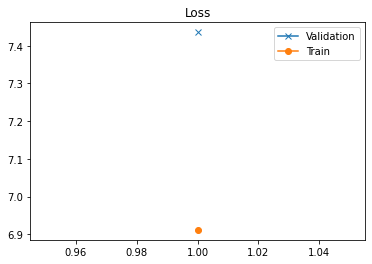

smallest val loss: (1, 7.435583)
Current Lr:  0.0009901111

Time taken for this epoch: 72.92 secs

Epoch 2 Batch 0 Loss 6.6619
Epoch 2 Batch 150 Loss 6.6906
Epoch 2 Batch 300 Loss 6.6901
Epoch 2 Batch 450 Loss 6.6866
Epoch 2 Batch 600 Loss 6.6804
Epoch 2 Batch 750 Loss 6.6714


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 7.870372295379639 

* Train Loss 6.6702


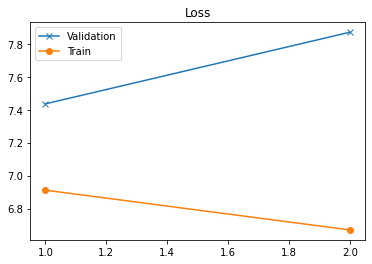

smallest val loss: (1, 7.435583)
Current Lr:  0.00098032

Time taken for this epoch: 48.44 secs

Epoch 3 Batch 0 Loss 6.6006
Epoch 3 Batch 150 Loss 6.5794
Epoch 3 Batch 300 Loss 6.6005
Epoch 3 Batch 450 Loss 6.6003
Epoch 3 Batch 600 Loss 6.5960
Epoch 3 Batch 750 Loss 6.5904


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 6.791703701019287 

* Train Loss 6.5906

 Saving checkpoint for epoch 3 at checkpoints4/ckpt-2


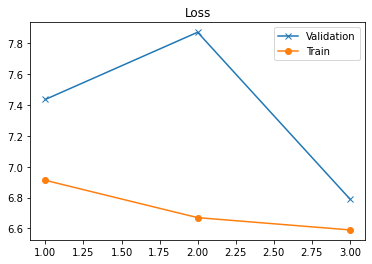

smallest val loss: (3, 6.7917037)
Current Lr:  0.00097062584

Time taken for this epoch: 48.43 secs

Epoch 4 Batch 0 Loss 6.3131
Epoch 4 Batch 150 Loss 6.5341
Epoch 4 Batch 300 Loss 6.5350
Epoch 4 Batch 450 Loss 6.5245
Epoch 4 Batch 600 Loss 6.5125
Epoch 4 Batch 750 Loss 6.5032


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 6.357940673828125 

* Train Loss 6.5023

 Saving checkpoint for epoch 4 at checkpoints4/ckpt-3


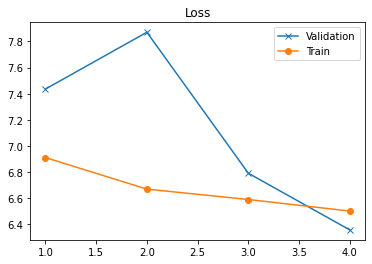

smallest val loss: (4, 6.3579407)
Current Lr:  0.0009610275

Time taken for this epoch: 48.34 secs

Epoch 5 Batch 0 Loss 6.2764
Epoch 5 Batch 150 Loss 6.4277
Epoch 5 Batch 300 Loss 6.4190
Epoch 5 Batch 450 Loss 6.4124
Epoch 5 Batch 600 Loss 6.4082
Epoch 5 Batch 750 Loss 6.4063


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 6.291389465332031 

* Train Loss 6.4055


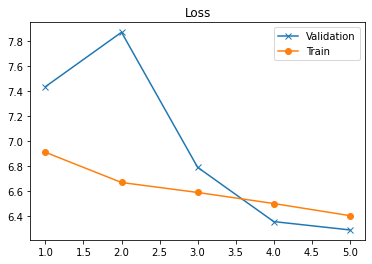

smallest val loss: (5, 6.2913895)
Current Lr:  0.00095152395

Time taken for this epoch: 47.91 secs

Epoch 6 Batch 0 Loss 6.3939
Epoch 6 Batch 150 Loss 6.3471
Epoch 6 Batch 300 Loss 6.3511
Epoch 6 Batch 450 Loss 6.3489
Epoch 6 Batch 600 Loss 6.3433
Epoch 6 Batch 750 Loss 6.3386


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 6.215907096862793 

* Train Loss 6.3384

 Saving checkpoint for epoch 6 at checkpoints4/ckpt-4


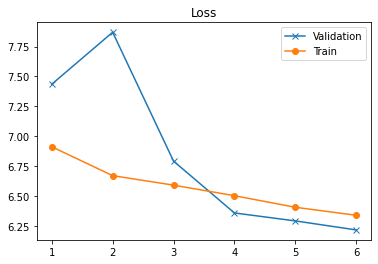

smallest val loss: (6, 6.215907)
Current Lr:  0.00094211457

Time taken for this epoch: 48.99 secs

Epoch 7 Batch 0 Loss 6.4056
Epoch 7 Batch 150 Loss 6.2758
Epoch 7 Batch 300 Loss 6.2722
Epoch 7 Batch 450 Loss 6.2709
Epoch 7 Batch 600 Loss 6.2606
Epoch 7 Batch 750 Loss 6.2469


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 6.104645252227783 

* Train Loss 6.2440

 Saving checkpoint for epoch 7 at checkpoints4/ckpt-5


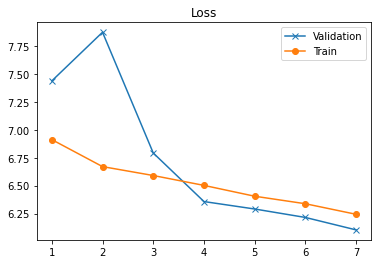

smallest val loss: (7, 6.1046453)
Current Lr:  0.0009327981

Time taken for this epoch: 47.99 secs

Epoch 8 Batch 0 Loss 6.1833
Epoch 8 Batch 150 Loss 6.1295
Epoch 8 Batch 300 Loss 6.1199
Epoch 8 Batch 450 Loss 6.1153
Epoch 8 Batch 600 Loss 6.1188
Epoch 8 Batch 750 Loss 6.1255


<UNK> <UNK> <UNK> <UNK> <UNK> in
<UNK> <UNK> <UNK> <UNK> <UNK> in
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> in


validation started ...

* Validation loss: 6.003148078918457 

* Train Loss 6.1251

 Saving checkpoint for epoch 8 at checkpoints4/ckpt-6


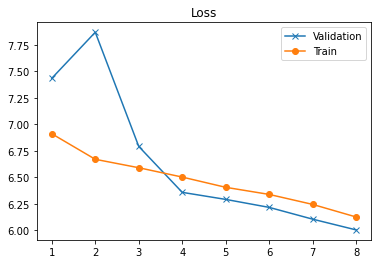

smallest val loss: (8, 6.003148)
Current Lr:  0.00092357374

Time taken for this epoch: 43.39 secs

Epoch 9 Batch 0 Loss 5.9292
Epoch 9 Batch 150 Loss 6.0340
Epoch 9 Batch 300 Loss 6.0399
Epoch 9 Batch 450 Loss 6.0345
Epoch 9 Batch 600 Loss 6.0290
Epoch 9 Batch 750 Loss 6.0218


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.942361354827881 

* Train Loss 6.0205


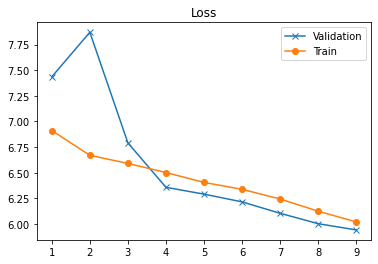

smallest val loss: (9, 5.9423614)
Current Lr:  0.0009144407

Time taken for this epoch: 47.86 secs

Epoch 10 Batch 0 Loss 5.9252
Epoch 10 Batch 150 Loss 5.9262
Epoch 10 Batch 300 Loss 5.9402
Epoch 10 Batch 450 Loss 5.9417
Epoch 10 Batch 600 Loss 5.9328
Epoch 10 Batch 750 Loss 5.9292


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.829737663269043 

* Train Loss 5.9293

 Saving checkpoint for epoch 10 at checkpoints4/ckpt-7


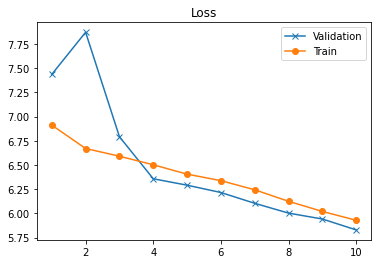

smallest val loss: (10, 5.8297377)
Current Lr:  0.00090539793

Time taken for this epoch: 44.43 secs

Epoch 11 Batch 0 Loss 5.9568
Epoch 11 Batch 150 Loss 5.8496
Epoch 11 Batch 300 Loss 5.8461
Epoch 11 Batch 450 Loss 5.8393
Epoch 11 Batch 600 Loss 5.8360
Epoch 11 Batch 750 Loss 5.8408


<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.78712272644043 

* Train Loss 5.8403


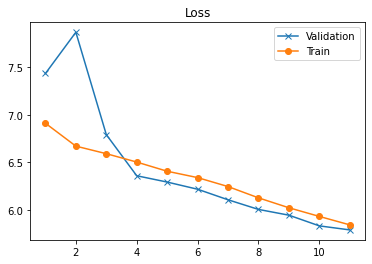

smallest val loss: (11, 5.7871227)
Current Lr:  0.00089644454

Time taken for this epoch: 43.93 secs

Epoch 12 Batch 0 Loss 5.6733
Epoch 12 Batch 150 Loss 5.7544
Epoch 12 Batch 300 Loss 5.7605
Epoch 12 Batch 450 Loss 5.7666
Epoch 12 Batch 600 Loss 5.7651
Epoch 12 Batch 750 Loss 5.7644


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.70969295501709 

* Train Loss 5.7636

 Saving checkpoint for epoch 12 at checkpoints4/ckpt-8


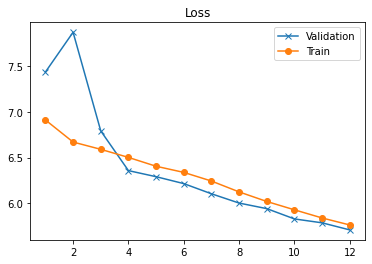

smallest val loss: (12, 5.709693)
Current Lr:  0.00088757975

Time taken for this epoch: 45.72 secs

Epoch 13 Batch 0 Loss 5.5989
Epoch 13 Batch 150 Loss 5.6853
Epoch 13 Batch 300 Loss 5.6962
Epoch 13 Batch 450 Loss 5.6914
Epoch 13 Batch 600 Loss 5.6901
Epoch 13 Batch 750 Loss 5.6932


<UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.653903961181641 

* Train Loss 5.6926


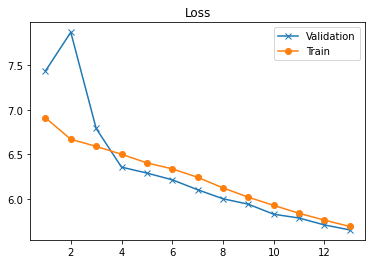

smallest val loss: (13, 5.653904)
Current Lr:  0.00087880256

Time taken for this epoch: 41.95 secs

Epoch 14 Batch 0 Loss 5.6548
Epoch 14 Batch 150 Loss 5.6543
Epoch 14 Batch 300 Loss 5.6595
Epoch 14 Batch 450 Loss 5.6484
Epoch 14 Batch 600 Loss 5.6450
Epoch 14 Batch 750 Loss 5.6422


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.589247226715088 

* Train Loss 5.6415

 Saving checkpoint for epoch 14 at checkpoints4/ckpt-9


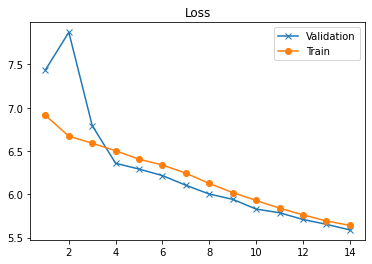

smallest val loss: (14, 5.589247)
Current Lr:  0.0008701122

Time taken for this epoch: 42.44 secs

Epoch 15 Batch 0 Loss 5.6877
Epoch 15 Batch 150 Loss 5.5671
Epoch 15 Batch 300 Loss 5.5649
Epoch 15 Batch 450 Loss 5.5638
Epoch 15 Batch 600 Loss 5.5625
Epoch 15 Batch 750 Loss 5.5652


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.514382839202881 

* Train Loss 5.5654


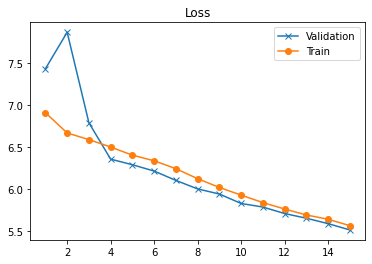

smallest val loss: (15, 5.514383)
Current Lr:  0.00086150784

Time taken for this epoch: 42.18 secs

Epoch 16 Batch 0 Loss 5.5001
Epoch 16 Batch 150 Loss 5.4811
Epoch 16 Batch 300 Loss 5.4949
Epoch 16 Batch 450 Loss 5.4993
Epoch 16 Batch 600 Loss 5.4990
Epoch 16 Batch 750 Loss 5.4998


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.449661731719971 

* Train Loss 5.5001

 Saving checkpoint for epoch 16 at checkpoints4/ckpt-10


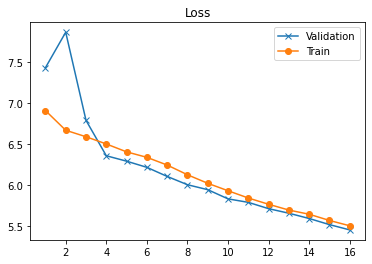

smallest val loss: (16, 5.4496617)
Current Lr:  0.00085298845

Time taken for this epoch: 43.17 secs

Epoch 17 Batch 0 Loss 5.4423
Epoch 17 Batch 150 Loss 5.4062
Epoch 17 Batch 300 Loss 5.4313
Epoch 17 Batch 450 Loss 5.4323
Epoch 17 Batch 600 Loss 5.4321
Epoch 17 Batch 750 Loss 5.4351


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.427720546722412 

* Train Loss 5.4363


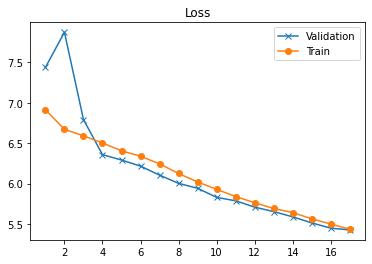

smallest val loss: (17, 5.4277205)
Current Lr:  0.0008445534

Time taken for this epoch: 42.46 secs

Epoch 18 Batch 0 Loss 5.3534
Epoch 18 Batch 150 Loss 5.3750
Epoch 18 Batch 300 Loss 5.3858
Epoch 18 Batch 450 Loss 5.3888
Epoch 18 Batch 600 Loss 5.3883
Epoch 18 Batch 750 Loss 5.3875


<UNK> <UNK> <UNK> <UNK> <UNK> in jampk
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.366464138031006 

* Train Loss 5.3879


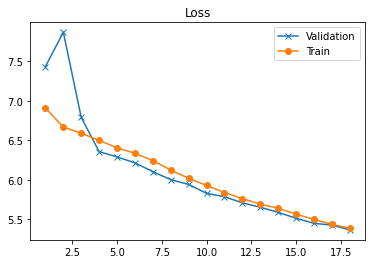

smallest val loss: (18, 5.366464)
Current Lr:  0.00083620177

Time taken for this epoch: 42.73 secs

Epoch 19 Batch 0 Loss 5.2389
Epoch 19 Batch 150 Loss 5.3213
Epoch 19 Batch 300 Loss 5.3234
Epoch 19 Batch 450 Loss 5.3305
Epoch 19 Batch 600 Loss 5.3380
Epoch 19 Batch 750 Loss 5.3430


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.351170063018799 

* Train Loss 5.3442


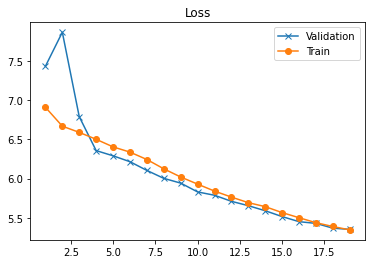

smallest val loss: (19, 5.35117)
Current Lr:  0.0008279326

Time taken for this epoch: 42.26 secs

Epoch 20 Batch 0 Loss 5.4802
Epoch 20 Batch 150 Loss 5.2879
Epoch 20 Batch 300 Loss 5.2899
Epoch 20 Batch 450 Loss 5.2958
Epoch 20 Batch 600 Loss 5.3059
Epoch 20 Batch 750 Loss 5.3104


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.326408863067627 

* Train Loss 5.3104

 Saving checkpoint for epoch 20 at checkpoints4/ckpt-11


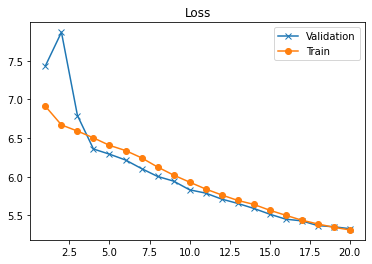

smallest val loss: (20, 5.326409)
Current Lr:  0.0008197454

Time taken for this epoch: 42.20 secs

Epoch 21 Batch 0 Loss 5.2843
Epoch 21 Batch 150 Loss 5.2194
Epoch 21 Batch 300 Loss 5.2569
Epoch 21 Batch 450 Loss 5.2636
Epoch 21 Batch 600 Loss 5.2703
Epoch 21 Batch 750 Loss 5.2770


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.2983269691467285 

* Train Loss 5.2773


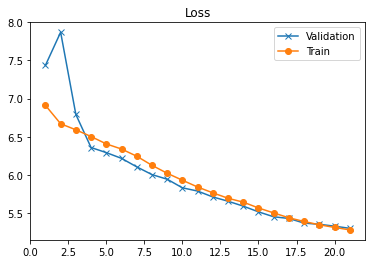

smallest val loss: (21, 5.298327)
Current Lr:  0.00081163907

Time taken for this epoch: 42.25 secs

Epoch 22 Batch 0 Loss 5.3049
Epoch 22 Batch 150 Loss 5.2093
Epoch 22 Batch 300 Loss 5.2284
Epoch 22 Batch 450 Loss 5.2352
Epoch 22 Batch 600 Loss 5.2386
Epoch 22 Batch 750 Loss 5.2468


<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.281154155731201 

* Train Loss 5.2468


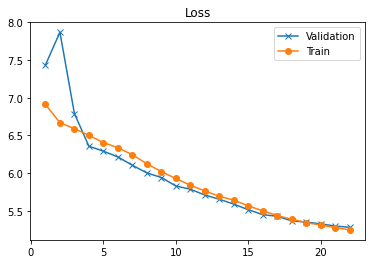

smallest val loss: (22, 5.281154)
Current Lr:  0.0008036128

Time taken for this epoch: 42.59 secs

Epoch 23 Batch 0 Loss 5.2159
Epoch 23 Batch 150 Loss 5.1939
Epoch 23 Batch 300 Loss 5.1984
Epoch 23 Batch 450 Loss 5.2019
Epoch 23 Batch 600 Loss 5.2090
Epoch 23 Batch 750 Loss 5.2187


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.253857135772705 

* Train Loss 5.2199


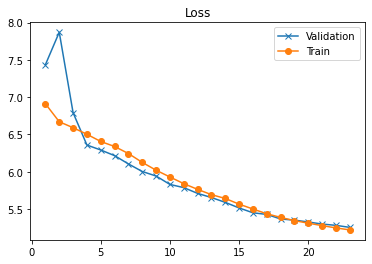

smallest val loss: (23, 5.253857)
Current Lr:  0.000795666

Time taken for this epoch: 43.10 secs

Epoch 24 Batch 0 Loss 5.2191
Epoch 24 Batch 150 Loss 5.1520
Epoch 24 Batch 300 Loss 5.1689
Epoch 24 Batch 450 Loss 5.1803
Epoch 24 Batch 600 Loss 5.1870
Epoch 24 Batch 750 Loss 5.1955


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.239537715911865 

* Train Loss 5.1969


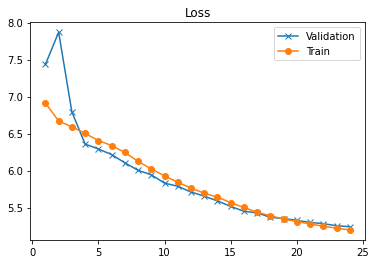

smallest val loss: (24, 5.2395377)
Current Lr:  0.0007877978

Time taken for this epoch: 42.25 secs

Epoch 25 Batch 0 Loss 5.1460
Epoch 25 Batch 150 Loss 5.1424
Epoch 25 Batch 300 Loss 5.1478
Epoch 25 Batch 450 Loss 5.1602
Epoch 25 Batch 600 Loss 5.1655
Epoch 25 Batch 750 Loss 5.1772


<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.236741065979004 

* Train Loss 5.1778


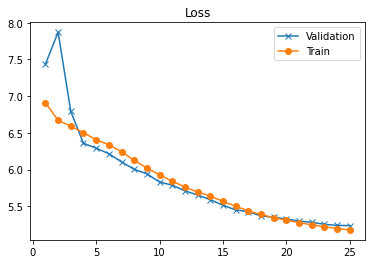

smallest val loss: (25, 5.236741)
Current Lr:  0.00078000734

Time taken for this epoch: 43.94 secs

Epoch 26 Batch 0 Loss 5.4282
Epoch 26 Batch 150 Loss 5.1290
Epoch 26 Batch 300 Loss 5.1435
Epoch 26 Batch 450 Loss 5.1515
Epoch 26 Batch 600 Loss 5.1620
Epoch 26 Batch 750 Loss 5.1673


<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india


validation started ...

* Validation loss: 5.242335796356201 

* Train Loss 5.1683


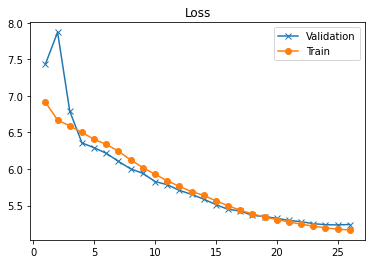

smallest val loss: (25, 5.236741)
Current Lr:  0.00077229395

Time taken for this epoch: 42.73 secs

Epoch 27 Batch 0 Loss 5.1937
Epoch 27 Batch 150 Loss 5.1093
Epoch 27 Batch 300 Loss 5.1204
Epoch 27 Batch 450 Loss 5.1241
Epoch 27 Batch 600 Loss 5.1346
Epoch 27 Batch 750 Loss 5.1467


<UNK> <UNK> to be <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.206847667694092 

* Train Loss 5.1485

 Saving checkpoint for epoch 27 at checkpoints4/ckpt-12


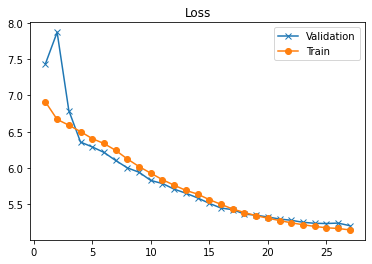

smallest val loss: (27, 5.2068477)
Current Lr:  0.00076465687

Time taken for this epoch: 42.69 secs

Epoch 28 Batch 0 Loss 5.2151
Epoch 28 Batch 150 Loss 5.0783
Epoch 28 Batch 300 Loss 5.1024
Epoch 28 Batch 450 Loss 5.1131
Epoch 28 Batch 600 Loss 5.1243
Epoch 28 Batch 750 Loss 5.1332


<UNK> <UNK> to be held in delhi
<UNK> <UNK> <UNK> to be held in delhi
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> to be held in delhi


validation started ...

* Validation loss: 5.217036247253418 

* Train Loss 5.1339


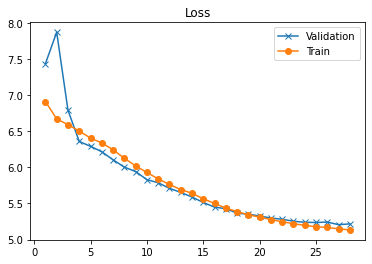

smallest val loss: (27, 5.2068477)
Current Lr:  0.00075709523

Time taken for this epoch: 43.66 secs

Epoch 29 Batch 0 Loss 5.1099
Epoch 29 Batch 150 Loss 5.0756
Epoch 29 Batch 300 Loss 5.0970
Epoch 29 Batch 450 Loss 5.1011
Epoch 29 Batch 600 Loss 5.1036
Epoch 29 Batch 750 Loss 5.1153


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.180907726287842 

* Train Loss 5.1159


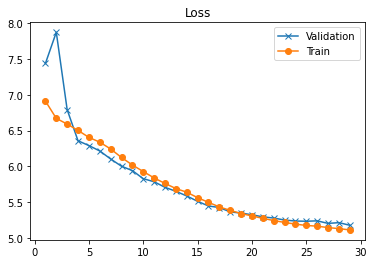

smallest val loss: (29, 5.1809077)
Current Lr:  0.0007496085

Time taken for this epoch: 42.07 secs

Epoch 30 Batch 0 Loss 4.9833
Epoch 30 Batch 150 Loss 5.0604
Epoch 30 Batch 300 Loss 5.0809
Epoch 30 Batch 450 Loss 5.0864
Epoch 30 Batch 600 Loss 5.0935
Epoch 30 Batch 750 Loss 5.1016


<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>


validation started ...

* Validation loss: 5.166590213775635 

* Train Loss 5.1034


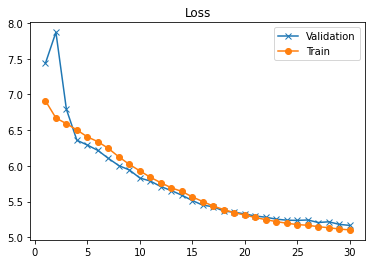

smallest val loss: (30, 5.16659)
Current Lr:  0.0007421957

Time taken for this epoch: 43.35 secs

Epoch 31 Batch 0 Loss 5.0699
Epoch 31 Batch 150 Loss 5.0442
Epoch 31 Batch 300 Loss 5.0641
Epoch 31 Batch 450 Loss 5.0714
Epoch 31 Batch 600 Loss 5.0814
Epoch 31 Batch 750 Loss 5.0862


<UNK> <UNK> to be <UNK> in
<UNK> <UNK> to be <UNK> in
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.17525577545166 

* Train Loss 5.0885


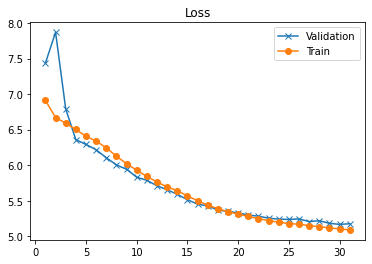

smallest val loss: (30, 5.16659)
Current Lr:  0.00073485624

Time taken for this epoch: 42.74 secs

Epoch 32 Batch 0 Loss 4.9903
Epoch 32 Batch 150 Loss 5.0384
Epoch 32 Batch 300 Loss 5.0494
Epoch 32 Batch 450 Loss 5.0533
Epoch 32 Batch 600 Loss 5.0638
Epoch 32 Batch 750 Loss 5.0717


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.17136287689209 

* Train Loss 5.0723


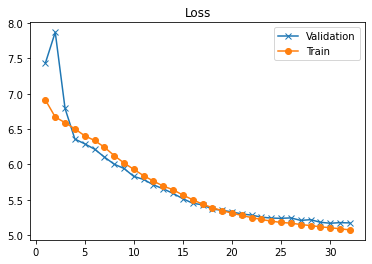

smallest val loss: (30, 5.16659)
Current Lr:  0.00072758936

Time taken for this epoch: 43.52 secs

Epoch 33 Batch 0 Loss 4.9666
Epoch 33 Batch 150 Loss 5.0095
Epoch 33 Batch 300 Loss 5.0291
Epoch 33 Batch 450 Loss 5.0429
Epoch 33 Batch 600 Loss 5.0512
Epoch 33 Batch 750 Loss 5.0613


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.161883354187012 

* Train Loss 5.0625


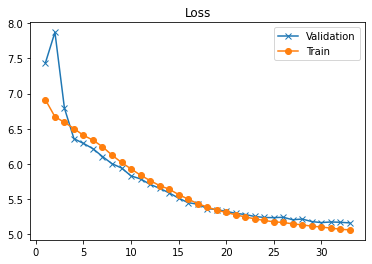

smallest val loss: (33, 5.1618834)
Current Lr:  0.00072039437

Time taken for this epoch: 43.16 secs

Epoch 34 Batch 0 Loss 5.1270
Epoch 34 Batch 150 Loss 4.9931
Epoch 34 Batch 300 Loss 5.0158
Epoch 34 Batch 450 Loss 5.0273
Epoch 34 Batch 600 Loss 5.0393
Epoch 34 Batch 750 Loss 5.0457


<UNK> <UNK> <UNK> to be held in delhi
<UNK> <UNK> <UNK> to be held in delhi
<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india


validation started ...

* Validation loss: 5.140622138977051 

* Train Loss 5.0487


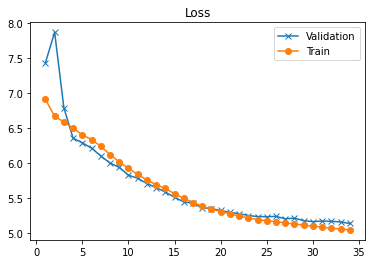

smallest val loss: (34, 5.140622)
Current Lr:  0.0007132704

Time taken for this epoch: 44.88 secs

Epoch 35 Batch 0 Loss 5.1165
Epoch 35 Batch 150 Loss 4.9926
Epoch 35 Batch 300 Loss 5.0108
Epoch 35 Batch 450 Loss 5.0247
Epoch 35 Batch 600 Loss 5.0315
Epoch 35 Batch 750 Loss 5.0425


<UNK> <UNK> <UNK> to be held in delhi
<UNK> <UNK> <UNK> to be held in delhi
<UNK> <UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india


validation started ...

* Validation loss: 5.187384605407715 

* Train Loss 5.0437


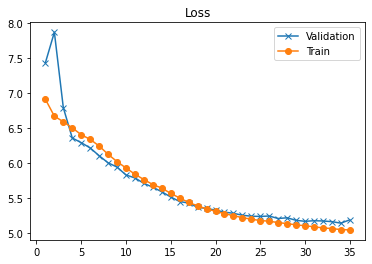

smallest val loss: (34, 5.140622)
Current Lr:  0.000706217

Time taken for this epoch: 45.82 secs

Epoch 36 Batch 0 Loss 4.9783
Epoch 36 Batch 150 Loss 4.9709
Epoch 36 Batch 300 Loss 5.0043
Epoch 36 Batch 450 Loss 5.0106
Epoch 36 Batch 600 Loss 5.0217
Epoch 36 Batch 750 Loss 5.0291


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.152419567108154 

* Train Loss 5.0315


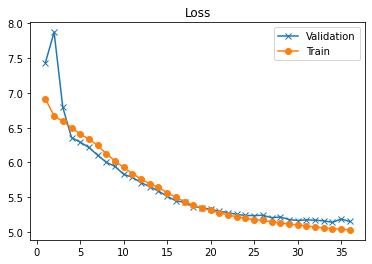

smallest val loss: (34, 5.140622)
Current Lr:  0.00069923326

Time taken for this epoch: 43.36 secs

Epoch 37 Batch 0 Loss 5.0245
Epoch 37 Batch 150 Loss 4.9849
Epoch 37 Batch 300 Loss 5.0065
Epoch 37 Batch 450 Loss 5.0123
Epoch 37 Batch 600 Loss 5.0158
Epoch 37 Batch 750 Loss 5.0240


<UNK> <UNK> to be held in delhi
<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india
<UNK> <UNK> to be <UNK> in india


validation started ...

* Validation loss: 5.131586074829102 

* Train Loss 5.0254


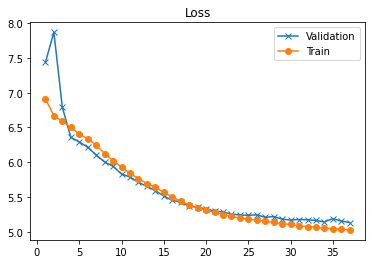

smallest val loss: (37, 5.131586)
Current Lr:  0.0006923187

Time taken for this epoch: 44.29 secs

Epoch 38 Batch 0 Loss 4.9059
Epoch 38 Batch 150 Loss 4.9602
Epoch 38 Batch 300 Loss 4.9827
Epoch 38 Batch 450 Loss 4.9921
Epoch 38 Batch 600 Loss 5.0028
Epoch 38 Batch 750 Loss 5.0187


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.122283458709717 

* Train Loss 5.0202


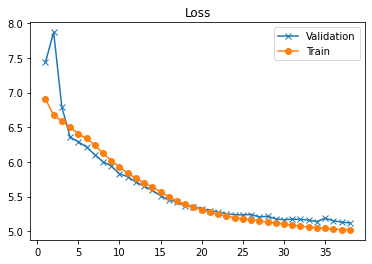

smallest val loss: (38, 5.1222835)
Current Lr:  0.00068547245

Time taken for this epoch: 43.02 secs

Epoch 39 Batch 0 Loss 4.6953
Epoch 39 Batch 150 Loss 4.9673
Epoch 39 Batch 300 Loss 4.9855
Epoch 39 Batch 450 Loss 4.9927
Epoch 39 Batch 600 Loss 5.0041
Epoch 39 Batch 750 Loss 5.0100


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.134889602661133 

* Train Loss 5.0124


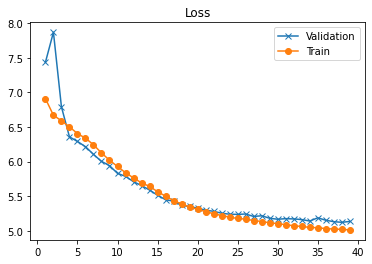

smallest val loss: (38, 5.1222835)
Current Lr:  0.00067869393

Time taken for this epoch: 42.30 secs

Epoch 40 Batch 0 Loss 4.9898
Epoch 40 Batch 150 Loss 4.9517
Epoch 40 Batch 300 Loss 4.9741
Epoch 40 Batch 450 Loss 4.9864
Epoch 40 Batch 600 Loss 4.9941
Epoch 40 Batch 750 Loss 5.0099


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.190698623657227 

* Train Loss 5.0121


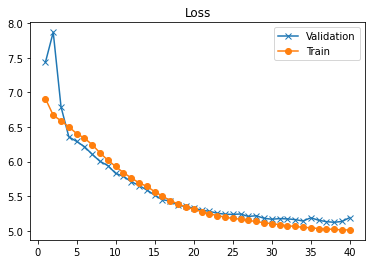

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006719824

Time taken for this epoch: 42.09 secs

Epoch 41 Batch 0 Loss 5.2788
Epoch 41 Batch 150 Loss 4.9959
Epoch 41 Batch 300 Loss 5.0181
Epoch 41 Batch 450 Loss 5.0302
Epoch 41 Batch 600 Loss 5.0435
Epoch 41 Batch 750 Loss 5.0531


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.1727166175842285 

* Train Loss 5.0558


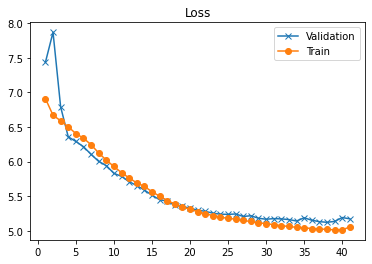

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006653373

Time taken for this epoch: 43.47 secs

Epoch 42 Batch 0 Loss 5.2277
Epoch 42 Batch 150 Loss 4.9898
Epoch 42 Batch 300 Loss 5.0148
Epoch 42 Batch 450 Loss 5.0219
Epoch 42 Batch 600 Loss 5.0323
Epoch 42 Batch 750 Loss 5.0454


<UNK> <UNK> <UNK> to be auctioned for cr
<UNK> <UNK> <UNK> to be auctioned for cr
<UNK> <UNK> <UNK> to be auctioned for cr
<UNK> <UNK> <UNK> to be auctioned for cr


validation started ...

* Validation loss: 5.178167343139648 

* Train Loss 5.0473


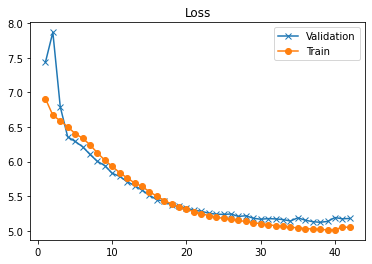

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006587578

Time taken for this epoch: 44.98 secs

Epoch 43 Batch 0 Loss 4.9948
Epoch 43 Batch 150 Loss 4.9843
Epoch 43 Batch 300 Loss 5.0030
Epoch 43 Batch 450 Loss 5.0171
Epoch 43 Batch 600 Loss 5.0273
Epoch 43 Batch 750 Loss 5.0382


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.168497085571289 

* Train Loss 5.0388


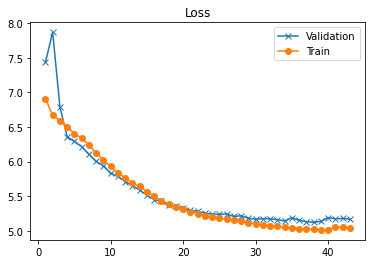

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006522435

Time taken for this epoch: 43.20 secs

Epoch 44 Batch 0 Loss 4.9476
Epoch 44 Batch 150 Loss 4.9847
Epoch 44 Batch 300 Loss 4.9994
Epoch 44 Batch 450 Loss 5.0109
Epoch 44 Batch 600 Loss 5.0247
Epoch 44 Batch 750 Loss 5.0325


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.144468307495117 

* Train Loss 5.0325


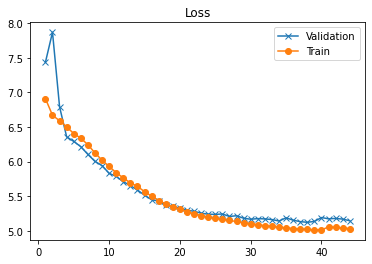

smallest val loss: (38, 5.1222835)
Current Lr:  0.00064579357

Time taken for this epoch: 41.79 secs

Epoch 45 Batch 0 Loss 4.9181
Epoch 45 Batch 150 Loss 4.9770
Epoch 45 Batch 300 Loss 4.9951
Epoch 45 Batch 450 Loss 4.9994
Epoch 45 Batch 600 Loss 5.0096
Epoch 45 Batch 750 Loss 5.0232


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.146951675415039 

* Train Loss 5.0257


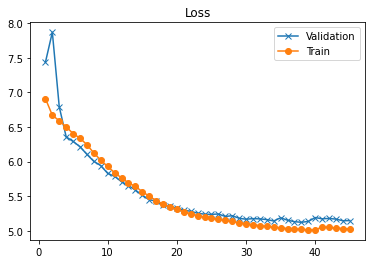

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006394074

Time taken for this epoch: 42.67 secs

Epoch 46 Batch 0 Loss 4.9208
Epoch 46 Batch 150 Loss 4.9728
Epoch 46 Batch 300 Loss 4.9916
Epoch 46 Batch 450 Loss 4.9992
Epoch 46 Batch 600 Loss 5.0071
Epoch 46 Batch 750 Loss 5.0202


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.151006698608398 

* Train Loss 5.0201


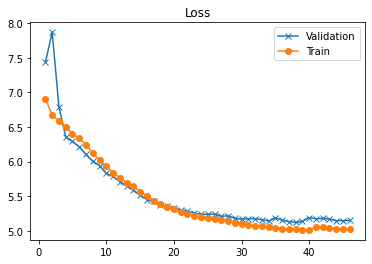

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006330844

Time taken for this epoch: 43.06 secs

Epoch 47 Batch 0 Loss 4.8882
Epoch 47 Batch 150 Loss 4.9586
Epoch 47 Batch 300 Loss 4.9857
Epoch 47 Batch 450 Loss 4.9877
Epoch 47 Batch 600 Loss 5.0005
Epoch 47 Batch 750 Loss 5.0112


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.141666412353516 

* Train Loss 5.0131


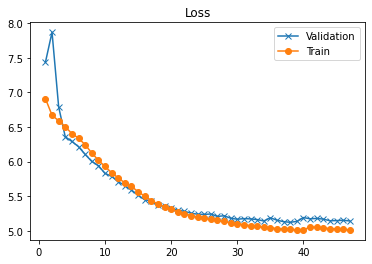

smallest val loss: (38, 5.1222835)
Current Lr:  0.00062682386

Time taken for this epoch: 42.56 secs

Epoch 48 Batch 0 Loss 5.1108
Epoch 48 Batch 150 Loss 4.9485
Epoch 48 Batch 300 Loss 4.9743
Epoch 48 Batch 450 Loss 4.9821
Epoch 48 Batch 600 Loss 4.9905
Epoch 48 Batch 750 Loss 5.0045


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.156152725219727 

* Train Loss 5.0060


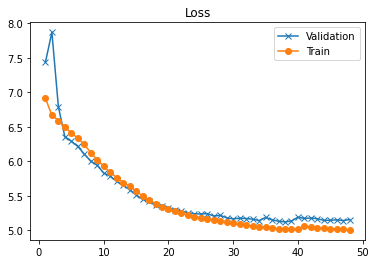

smallest val loss: (38, 5.1222835)
Current Lr:  0.00062062533

Time taken for this epoch: 42.77 secs

Epoch 49 Batch 0 Loss 4.8351
Epoch 49 Batch 150 Loss 4.9329
Epoch 49 Batch 300 Loss 4.9634
Epoch 49 Batch 450 Loss 4.9796
Epoch 49 Batch 600 Loss 4.9885
Epoch 49 Batch 750 Loss 5.0007


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.1459479331970215 

* Train Loss 5.0019


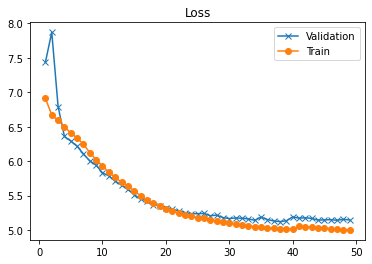

smallest val loss: (38, 5.1222835)
Current Lr:  0.00061448803

Time taken for this epoch: 41.04 secs

Epoch 50 Batch 0 Loss 4.6680
Epoch 50 Batch 150 Loss 4.9390
Epoch 50 Batch 300 Loss 4.9637
Epoch 50 Batch 450 Loss 4.9693
Epoch 50 Batch 600 Loss 4.9807
Epoch 50 Batch 750 Loss 4.9948


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.130657196044922 

* Train Loss 4.9959


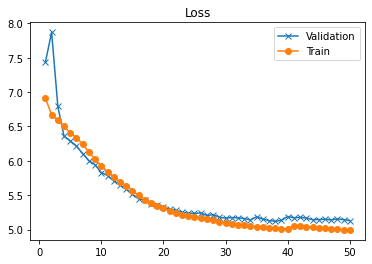

smallest val loss: (38, 5.1222835)
Current Lr:  0.00060841144

Time taken for this epoch: 42.64 secs

Epoch 51 Batch 0 Loss 4.8892
Epoch 51 Batch 150 Loss 4.9163
Epoch 51 Batch 300 Loss 4.9498
Epoch 51 Batch 450 Loss 4.9644
Epoch 51 Batch 600 Loss 4.9768
Epoch 51 Batch 750 Loss 4.9879


<UNK> <UNK> <UNK> <UNK> to be <UNK>
<UNK> <UNK> <UNK> <UNK> to be <UNK>
<UNK> <UNK> <UNK> <UNK> to be <UNK>
<UNK> <UNK> <UNK> <UNK> to be <UNK>


validation started ...

* Validation loss: 5.134743690490723 

* Train Loss 4.9901


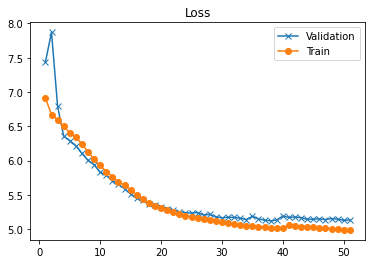

smallest val loss: (38, 5.1222835)
Current Lr:  0.0006023949

Time taken for this epoch: 44.00 secs

Epoch 52 Batch 0 Loss 4.7580
Epoch 52 Batch 150 Loss 4.9177
Epoch 52 Batch 300 Loss 4.9477
Epoch 52 Batch 450 Loss 4.9599
Epoch 52 Batch 600 Loss 4.9720
Epoch 52 Batch 750 Loss 4.9843


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.151712894439697 

* Train Loss 4.9857


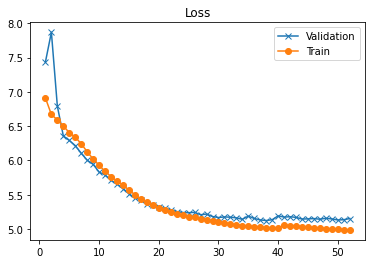

smallest val loss: (38, 5.1222835)
Current Lr:  0.000596438

Time taken for this epoch: 42.94 secs

Epoch 53 Batch 0 Loss 4.9993
Epoch 53 Batch 150 Loss 4.9285
Epoch 53 Batch 300 Loss 4.9476
Epoch 53 Batch 450 Loss 4.9608
Epoch 53 Batch 600 Loss 4.9673
Epoch 53 Batch 750 Loss 4.9786


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.148020267486572 

* Train Loss 4.9808


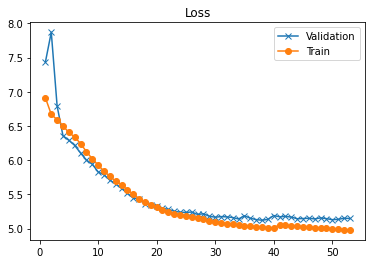

smallest val loss: (38, 5.1222835)
Current Lr:  0.0005905398

Time taken for this epoch: 43.01 secs

Epoch 54 Batch 0 Loss 4.9683
Epoch 54 Batch 150 Loss 4.9178
Epoch 54 Batch 300 Loss 4.9382
Epoch 54 Batch 450 Loss 4.9570
Epoch 54 Batch 600 Loss 4.9662
Epoch 54 Batch 750 Loss 4.9757


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.142408847808838 

* Train Loss 4.9760


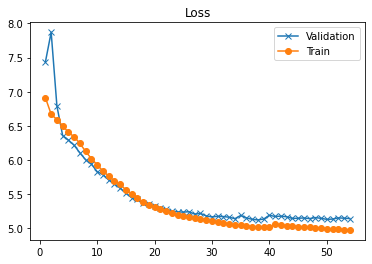

smallest val loss: (38, 5.1222835)
Current Lr:  0.00058470014

Time taken for this epoch: 44.44 secs

Epoch 55 Batch 0 Loss 4.8167
Epoch 55 Batch 150 Loss 4.9109
Epoch 55 Batch 300 Loss 4.9304
Epoch 55 Batch 450 Loss 4.9457
Epoch 55 Batch 600 Loss 4.9582
Epoch 55 Batch 750 Loss 4.9698


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.129984378814697 

* Train Loss 4.9716


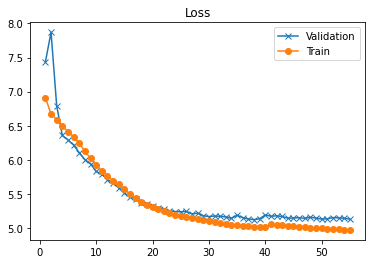

smallest val loss: (38, 5.1222835)
Current Lr:  0.00057891815

Time taken for this epoch: 43.28 secs

Epoch 56 Batch 0 Loss 5.0120
Epoch 56 Batch 150 Loss 4.9189
Epoch 56 Batch 300 Loss 4.9364
Epoch 56 Batch 450 Loss 4.9422
Epoch 56 Batch 600 Loss 4.9520
Epoch 56 Batch 750 Loss 4.9646


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.135932445526123 

* Train Loss 4.9660


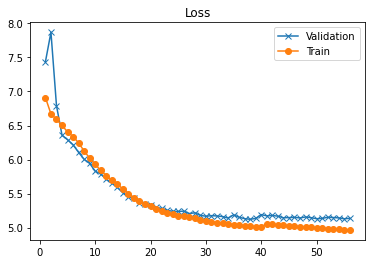

smallest val loss: (38, 5.1222835)
Current Lr:  0.00057319325

Time taken for this epoch: 43.38 secs

Epoch 57 Batch 0 Loss 4.9395
Epoch 57 Batch 150 Loss 4.9002
Epoch 57 Batch 300 Loss 4.9225
Epoch 57 Batch 450 Loss 4.9342
Epoch 57 Batch 600 Loss 4.9484
Epoch 57 Batch 750 Loss 4.9596


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.136171340942383 

* Train Loss 4.9612


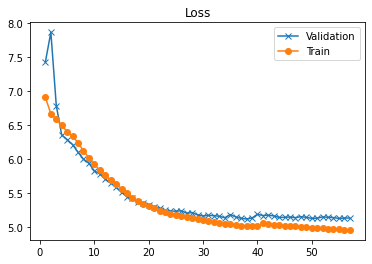

smallest val loss: (38, 5.1222835)
Current Lr:  0.00056752504

Time taken for this epoch: 43.68 secs

Epoch 58 Batch 0 Loss 4.7969
Epoch 58 Batch 150 Loss 4.8972
Epoch 58 Batch 300 Loss 4.9197
Epoch 58 Batch 450 Loss 4.9346
Epoch 58 Batch 600 Loss 4.9466
Epoch 58 Batch 750 Loss 4.9574


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.13140869140625 

* Train Loss 4.9600


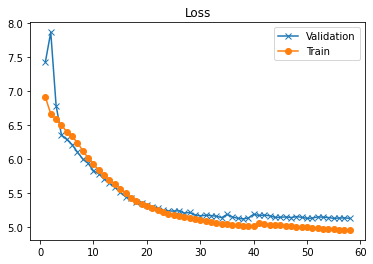

smallest val loss: (38, 5.1222835)
Current Lr:  0.0005619129

Time taken for this epoch: 42.88 secs

Epoch 59 Batch 0 Loss 5.0366
Epoch 59 Batch 150 Loss 4.8974
Epoch 59 Batch 300 Loss 4.9166
Epoch 59 Batch 450 Loss 4.9291
Epoch 59 Batch 600 Loss 4.9417
Epoch 59 Batch 750 Loss 4.9524


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.118167877197266 

* Train Loss 4.9545


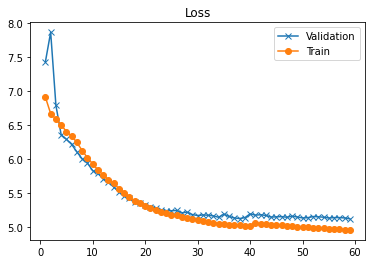

smallest val loss: (59, 5.118168)
Current Lr:  0.00055635616

Time taken for this epoch: 39.13 secs

Epoch 60 Batch 0 Loss 4.5882
Epoch 60 Batch 150 Loss 4.8976
Epoch 60 Batch 300 Loss 4.9162
Epoch 60 Batch 450 Loss 4.9345
Epoch 60 Batch 600 Loss 4.9419
Epoch 60 Batch 750 Loss 4.9508


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.142938613891602 

* Train Loss 4.9519


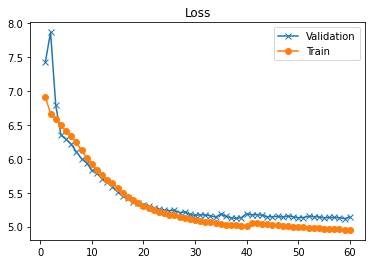

smallest val loss: (59, 5.118168)
Current Lr:  0.0005508545

Time taken for this epoch: 39.11 secs

Epoch 61 Batch 0 Loss 5.0457
Epoch 61 Batch 150 Loss 4.8986
Epoch 61 Batch 300 Loss 4.9092
Epoch 61 Batch 450 Loss 4.9243
Epoch 61 Batch 600 Loss 4.9370
Epoch 61 Batch 750 Loss 4.9450


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.117742538452148 

* Train Loss 4.9465


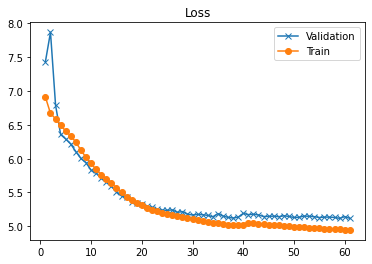

smallest val loss: (61, 5.1177425)
Current Lr:  0.0005454071

Time taken for this epoch: 39.13 secs

Epoch 62 Batch 0 Loss 4.9088
Epoch 62 Batch 150 Loss 4.8870
Epoch 62 Batch 300 Loss 4.9107
Epoch 62 Batch 450 Loss 4.9205
Epoch 62 Batch 600 Loss 4.9295
Epoch 62 Batch 750 Loss 4.9430


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.128010272979736 

* Train Loss 4.9453


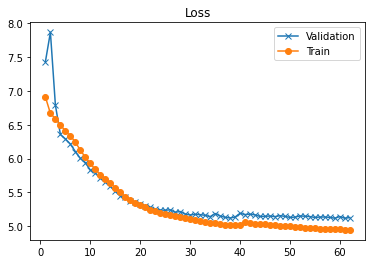

smallest val loss: (61, 5.1177425)
Current Lr:  0.00054001366

Time taken for this epoch: 39.26 secs

Epoch 63 Batch 0 Loss 4.9610
Epoch 63 Batch 150 Loss 4.8837
Epoch 63 Batch 300 Loss 4.9060
Epoch 63 Batch 450 Loss 4.9226
Epoch 63 Batch 600 Loss 4.9326
Epoch 63 Batch 750 Loss 4.9418


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.123414993286133 

* Train Loss 4.9428


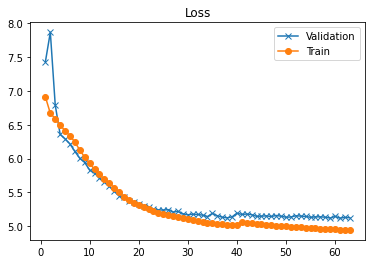

smallest val loss: (61, 5.1177425)
Current Lr:  0.0005346735

Time taken for this epoch: 39.14 secs

Epoch 64 Batch 0 Loss 4.9161
Epoch 64 Batch 150 Loss 4.8852
Epoch 64 Batch 300 Loss 4.8995
Epoch 64 Batch 450 Loss 4.9167
Epoch 64 Batch 600 Loss 4.9250
Epoch 64 Batch 750 Loss 4.9360


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.144927024841309 

* Train Loss 4.9387


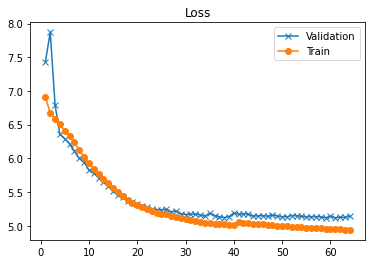

smallest val loss: (61, 5.1177425)
Current Lr:  0.0005293862

Time taken for this epoch: 39.13 secs

Epoch 65 Batch 0 Loss 4.8552
Epoch 65 Batch 150 Loss 4.8641
Epoch 65 Batch 300 Loss 4.8973
Epoch 65 Batch 450 Loss 4.9134
Epoch 65 Batch 600 Loss 4.9268
Epoch 65 Batch 750 Loss 4.9336


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.123740196228027 

* Train Loss 4.9355


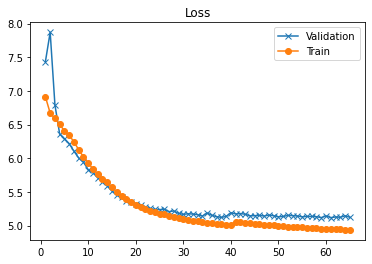

smallest val loss: (61, 5.1177425)
Current Lr:  0.0005241512

Time taken for this epoch: 39.32 secs

Epoch 66 Batch 0 Loss 4.8464
Epoch 66 Batch 150 Loss 4.8677
Epoch 66 Batch 300 Loss 4.8926
Epoch 66 Batch 450 Loss 4.9038
Epoch 66 Batch 600 Loss 4.9190
Epoch 66 Batch 750 Loss 4.9295


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.127462387084961 

* Train Loss 4.9321


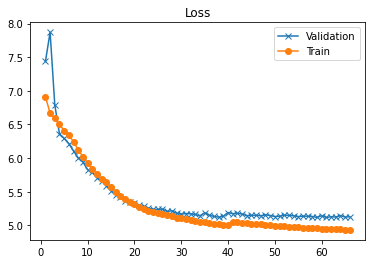

smallest val loss: (61, 5.1177425)
Current Lr:  0.000518968

Time taken for this epoch: 39.56 secs

Epoch 67 Batch 0 Loss 4.8843
Epoch 67 Batch 150 Loss 4.8592
Epoch 67 Batch 300 Loss 4.8878
Epoch 67 Batch 450 Loss 4.9056
Epoch 67 Batch 600 Loss 4.9173
Epoch 67 Batch 750 Loss 4.9280


<UNK> <UNK> to be <UNK> by <UNK>
<UNK> <UNK> to be <UNK> by <UNK>
<UNK> <UNK> to be <UNK> by <UNK>
<UNK> <UNK> to be <UNK> by <UNK>


validation started ...

* Validation loss: 5.093856334686279 

* Train Loss 4.9296

 Saving checkpoint for epoch 67 at checkpoints4/ckpt-13


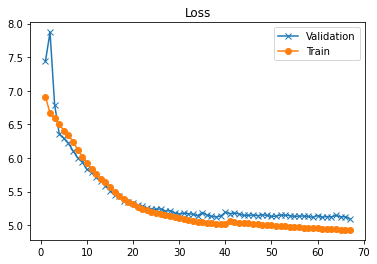

smallest val loss: (67, 5.0938563)
Current Lr:  0.0005138359

Time taken for this epoch: 40.97 secs

Epoch 68 Batch 0 Loss 4.9149
Epoch 68 Batch 150 Loss 4.8688
Epoch 68 Batch 300 Loss 4.8927
Epoch 68 Batch 450 Loss 4.8999
Epoch 68 Batch 600 Loss 4.9110
Epoch 68 Batch 750 Loss 4.9242


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.103217601776123 

* Train Loss 4.9242


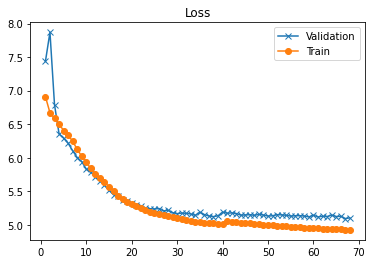

smallest val loss: (67, 5.0938563)
Current Lr:  0.0005087547

Time taken for this epoch: 39.87 secs

Epoch 69 Batch 0 Loss 4.8764
Epoch 69 Batch 150 Loss 4.8606
Epoch 69 Batch 300 Loss 4.8822
Epoch 69 Batch 450 Loss 4.8998
Epoch 69 Batch 600 Loss 4.9115
Epoch 69 Batch 750 Loss 4.9219


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.102242946624756 

* Train Loss 4.9228


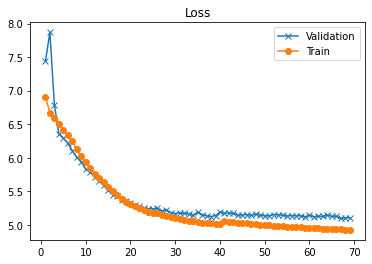

smallest val loss: (67, 5.0938563)
Current Lr:  0.00050372374

Time taken for this epoch: 38.99 secs

Epoch 70 Batch 0 Loss 5.1106
Epoch 70 Batch 150 Loss 4.8565
Epoch 70 Batch 300 Loss 4.8792
Epoch 70 Batch 450 Loss 4.8948
Epoch 70 Batch 600 Loss 4.9044
Epoch 70 Batch 750 Loss 4.9175


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.130250930786133 

* Train Loss 4.9205


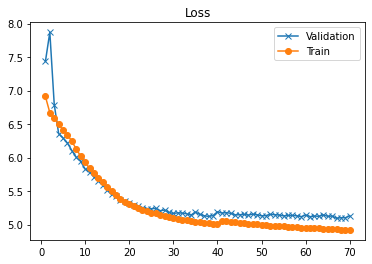

smallest val loss: (67, 5.0938563)
Current Lr:  0.0004987425

Time taken for this epoch: 39.81 secs

Epoch 71 Batch 0 Loss 4.9341
Epoch 71 Batch 150 Loss 4.8472
Epoch 71 Batch 300 Loss 4.8765
Epoch 71 Batch 450 Loss 4.8928
Epoch 71 Batch 600 Loss 4.9006
Epoch 71 Batch 750 Loss 4.9128


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.098583698272705 

* Train Loss 4.9159


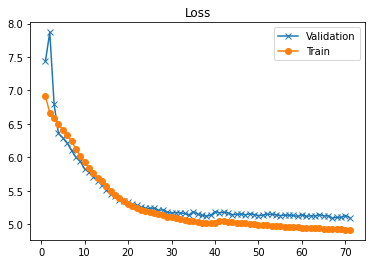

smallest val loss: (67, 5.0938563)
Current Lr:  0.0004938104

Time taken for this epoch: 38.92 secs

Epoch 72 Batch 0 Loss 4.9868
Epoch 72 Batch 150 Loss 4.8457
Epoch 72 Batch 300 Loss 4.8713
Epoch 72 Batch 450 Loss 4.8854
Epoch 72 Batch 600 Loss 4.8986
Epoch 72 Batch 750 Loss 4.9103


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.09815788269043 

* Train Loss 4.9126


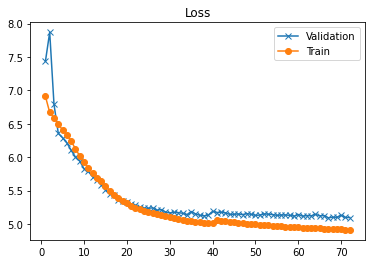

smallest val loss: (67, 5.0938563)
Current Lr:  0.0004889273

Time taken for this epoch: 39.90 secs

Epoch 73 Batch 0 Loss 4.8234
Epoch 73 Batch 150 Loss 4.8609
Epoch 73 Batch 300 Loss 4.8746
Epoch 73 Batch 450 Loss 4.8888
Epoch 73 Batch 600 Loss 4.8977
Epoch 73 Batch 750 Loss 4.9070


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.122676849365234 

* Train Loss 4.9097


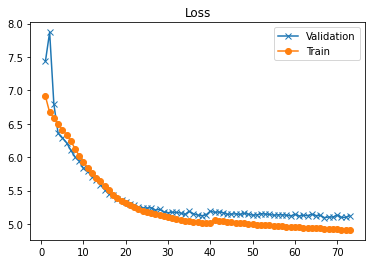

smallest val loss: (67, 5.0938563)
Current Lr:  0.00048409228

Time taken for this epoch: 39.03 secs

Epoch 74 Batch 0 Loss 4.9104
Epoch 74 Batch 150 Loss 4.8618
Epoch 74 Batch 300 Loss 4.8701
Epoch 74 Batch 450 Loss 4.8832
Epoch 74 Batch 600 Loss 4.8941
Epoch 74 Batch 750 Loss 4.9044


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.114297866821289 

* Train Loss 4.9064


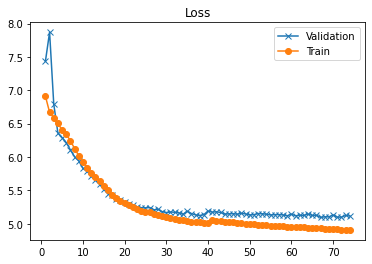

smallest val loss: (67, 5.0938563)
Current Lr:  0.00047930522

Time taken for this epoch: 39.87 secs

Epoch 75 Batch 0 Loss 4.6811
Epoch 75 Batch 150 Loss 4.8525
Epoch 75 Batch 300 Loss 4.8647
Epoch 75 Batch 450 Loss 4.8783
Epoch 75 Batch 600 Loss 4.8884
Epoch 75 Batch 750 Loss 4.9021


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.117339611053467 

* Train Loss 4.9022


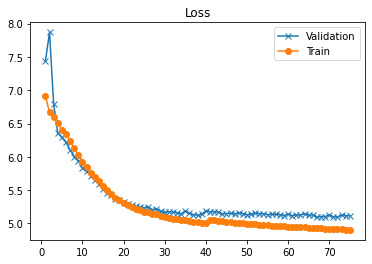

smallest val loss: (67, 5.0938563)
Current Lr:  0.00047456537

Time taken for this epoch: 39.15 secs

Epoch 76 Batch 0 Loss 4.8974
Epoch 76 Batch 150 Loss 4.8689
Epoch 76 Batch 300 Loss 4.8736
Epoch 76 Batch 450 Loss 4.8883
Epoch 76 Batch 600 Loss 4.8945
Epoch 76 Batch 750 Loss 4.9013


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101165294647217 

* Train Loss 4.9025


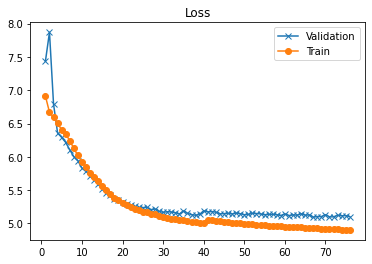

smallest val loss: (67, 5.0938563)
Current Lr:  0.00046987247

Time taken for this epoch: 39.02 secs

Epoch 77 Batch 0 Loss 4.9282
Epoch 77 Batch 150 Loss 4.8511
Epoch 77 Batch 300 Loss 4.8713
Epoch 77 Batch 450 Loss 4.8781
Epoch 77 Batch 600 Loss 4.8870
Epoch 77 Batch 750 Loss 4.8966


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.10164213180542 

* Train Loss 4.8983


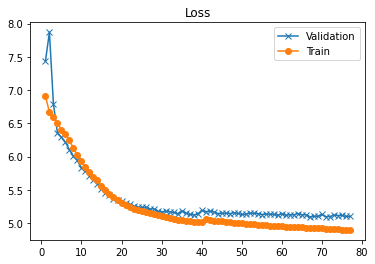

smallest val loss: (67, 5.0938563)
Current Lr:  0.000465226

Time taken for this epoch: 39.24 secs

Epoch 78 Batch 0 Loss 4.9321
Epoch 78 Batch 150 Loss 4.8349
Epoch 78 Batch 300 Loss 4.8608
Epoch 78 Batch 450 Loss 4.8707
Epoch 78 Batch 600 Loss 4.8861
Epoch 78 Batch 750 Loss 4.8956


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.096539497375488 

* Train Loss 4.8963


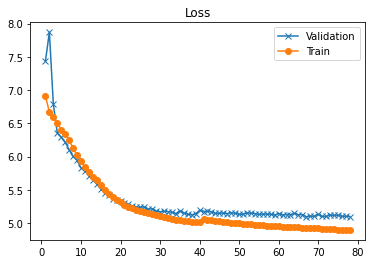

smallest val loss: (67, 5.0938563)
Current Lr:  0.0004606254

Time taken for this epoch: 39.14 secs

Epoch 79 Batch 0 Loss 4.7777
Epoch 79 Batch 150 Loss 4.8197
Epoch 79 Batch 300 Loss 4.8522
Epoch 79 Batch 450 Loss 4.8633
Epoch 79 Batch 600 Loss 4.8751
Epoch 79 Batch 750 Loss 4.8897


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.096519947052002 

* Train Loss 4.8923


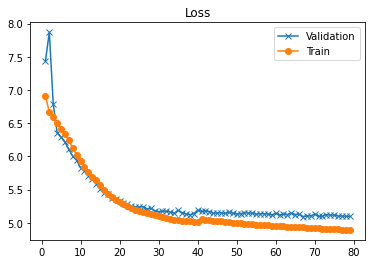

smallest val loss: (67, 5.0938563)
Current Lr:  0.00045607038

Time taken for this epoch: 39.17 secs

Epoch 80 Batch 0 Loss 5.0482
Epoch 80 Batch 150 Loss 4.8455
Epoch 80 Batch 300 Loss 4.8508
Epoch 80 Batch 450 Loss 4.8717
Epoch 80 Batch 600 Loss 4.8800
Epoch 80 Batch 750 Loss 4.8889


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.110844135284424 

* Train Loss 4.8894


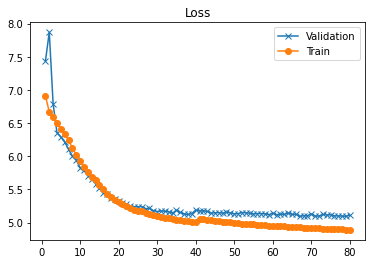

smallest val loss: (67, 5.0938563)
Current Lr:  0.0004515604

Time taken for this epoch: 39.20 secs

Epoch 81 Batch 0 Loss 4.6983
Epoch 81 Batch 150 Loss 4.8221
Epoch 81 Batch 300 Loss 4.8501
Epoch 81 Batch 450 Loss 4.8637
Epoch 81 Batch 600 Loss 4.8753
Epoch 81 Batch 750 Loss 4.8842


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.140438079833984 

* Train Loss 4.8863


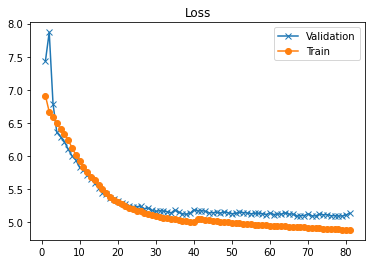

smallest val loss: (67, 5.0938563)
Current Lr:  0.00044709494

Time taken for this epoch: 39.19 secs

Epoch 82 Batch 0 Loss 4.7652
Epoch 82 Batch 150 Loss 4.8332
Epoch 82 Batch 300 Loss 4.8515
Epoch 82 Batch 450 Loss 4.8612
Epoch 82 Batch 600 Loss 4.8710
Epoch 82 Batch 750 Loss 4.8826


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.102536201477051 

* Train Loss 4.8844


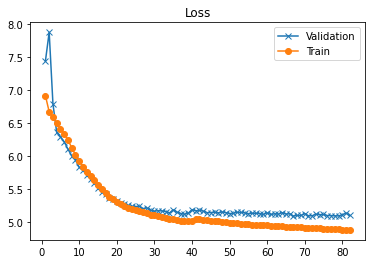

smallest val loss: (67, 5.0938563)
Current Lr:  0.00044267369

Time taken for this epoch: 39.67 secs

Epoch 83 Batch 0 Loss 4.7038
Epoch 83 Batch 150 Loss 4.8149
Epoch 83 Batch 300 Loss 4.8431
Epoch 83 Batch 450 Loss 4.8535
Epoch 83 Batch 600 Loss 4.8671
Epoch 83 Batch 750 Loss 4.8785


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.090791702270508 

* Train Loss 4.8808


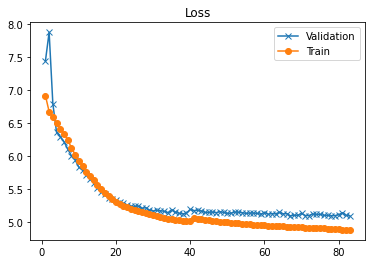

smallest val loss: (83, 5.0907917)
Current Lr:  0.00043829618

Time taken for this epoch: 39.11 secs

Epoch 84 Batch 0 Loss 4.8000
Epoch 84 Batch 150 Loss 4.8210
Epoch 84 Batch 300 Loss 4.8489
Epoch 84 Batch 450 Loss 4.8634
Epoch 84 Batch 600 Loss 4.8685
Epoch 84 Batch 750 Loss 4.8769


<UNK> <UNK> to be <UNK> by <UNK>
<UNK> <UNK> to be <UNK> by <UNK>
<UNK> <UNK> to be <UNK> by <UNK>
<UNK> <UNK> to be <UNK> by <UNK>


validation started ...

* Validation loss: 5.122747898101807 

* Train Loss 4.8785


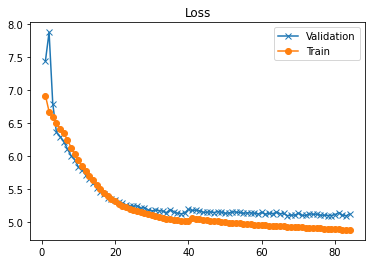

smallest val loss: (83, 5.0907917)
Current Lr:  0.00043396192

Time taken for this epoch: 40.54 secs

Epoch 85 Batch 0 Loss 4.9332
Epoch 85 Batch 150 Loss 4.8200
Epoch 85 Batch 300 Loss 4.8434
Epoch 85 Batch 450 Loss 4.8573
Epoch 85 Batch 600 Loss 4.8651
Epoch 85 Batch 750 Loss 4.8742


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.097896575927734 

* Train Loss 4.8769


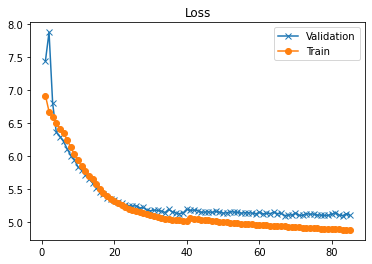

smallest val loss: (83, 5.0907917)
Current Lr:  0.0004296705

Time taken for this epoch: 39.19 secs

Epoch 86 Batch 0 Loss 4.9846
Epoch 86 Batch 150 Loss 4.8186
Epoch 86 Batch 300 Loss 4.8416
Epoch 86 Batch 450 Loss 4.8551
Epoch 86 Batch 600 Loss 4.8641
Epoch 86 Batch 750 Loss 4.8743


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.0849714279174805 

* Train Loss 4.8757


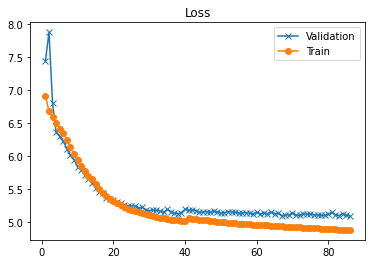

smallest val loss: (86, 5.0849714)
Current Lr:  0.00042542157

Time taken for this epoch: 39.07 secs

Epoch 87 Batch 0 Loss 5.0188
Epoch 87 Batch 150 Loss 4.8089
Epoch 87 Batch 300 Loss 4.8317
Epoch 87 Batch 450 Loss 4.8471
Epoch 87 Batch 600 Loss 4.8589
Epoch 87 Batch 750 Loss 4.8689


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.096274375915527 

* Train Loss 4.8709


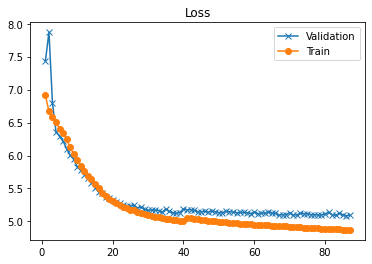

smallest val loss: (86, 5.0849714)
Current Lr:  0.0004212146

Time taken for this epoch: 39.09 secs

Epoch 88 Batch 0 Loss 5.0453
Epoch 88 Batch 150 Loss 4.8299
Epoch 88 Batch 300 Loss 4.8394
Epoch 88 Batch 450 Loss 4.8438
Epoch 88 Batch 600 Loss 4.8551
Epoch 88 Batch 750 Loss 4.8664


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.097031116485596 

* Train Loss 4.8686


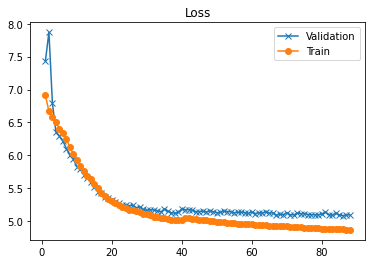

smallest val loss: (86, 5.0849714)
Current Lr:  0.00041704928

Time taken for this epoch: 38.89 secs

Epoch 89 Batch 0 Loss 4.8618
Epoch 89 Batch 150 Loss 4.8081
Epoch 89 Batch 300 Loss 4.8297
Epoch 89 Batch 450 Loss 4.8426
Epoch 89 Batch 600 Loss 4.8530
Epoch 89 Batch 750 Loss 4.8594


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.1055192947387695 

* Train Loss 4.8626


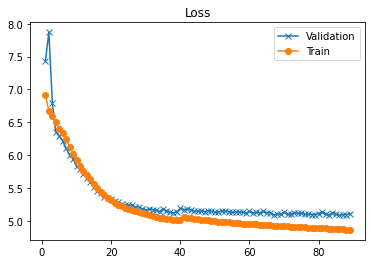

smallest val loss: (86, 5.0849714)
Current Lr:  0.00041292518

Time taken for this epoch: 39.08 secs

Epoch 90 Batch 0 Loss 4.7026
Epoch 90 Batch 150 Loss 4.8088
Epoch 90 Batch 300 Loss 4.8257
Epoch 90 Batch 450 Loss 4.8383
Epoch 90 Batch 600 Loss 4.8494
Epoch 90 Batch 750 Loss 4.8600


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.121740341186523 

* Train Loss 4.8616


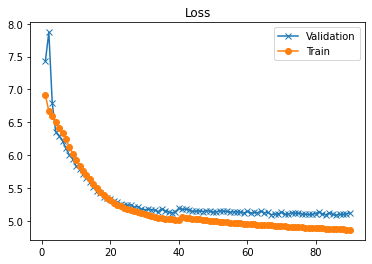

smallest val loss: (86, 5.0849714)
Current Lr:  0.0004088418

Time taken for this epoch: 39.05 secs

Epoch 91 Batch 0 Loss 4.8505
Epoch 91 Batch 150 Loss 4.8010
Epoch 91 Batch 300 Loss 4.8220
Epoch 91 Batch 450 Loss 4.8367
Epoch 91 Batch 600 Loss 4.8453
Epoch 91 Batch 750 Loss 4.8583


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.112724781036377 

* Train Loss 4.8607


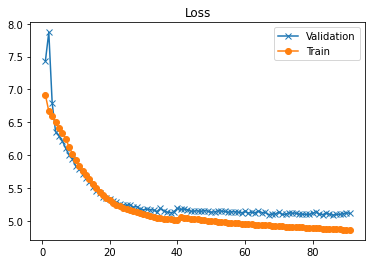

smallest val loss: (86, 5.0849714)
Current Lr:  0.00040479883

Time taken for this epoch: 39.13 secs

Epoch 92 Batch 0 Loss 4.8485
Epoch 92 Batch 150 Loss 4.8153
Epoch 92 Batch 300 Loss 4.8328
Epoch 92 Batch 450 Loss 4.8404
Epoch 92 Batch 600 Loss 4.8463
Epoch 92 Batch 750 Loss 4.8544


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.081131458282471 

* Train Loss 4.8571


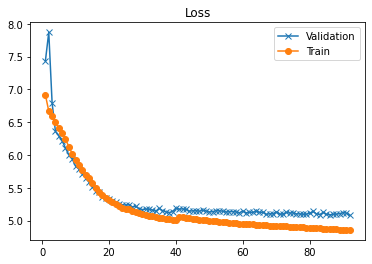

smallest val loss: (92, 5.0811315)
Current Lr:  0.00040079583

Time taken for this epoch: 38.99 secs

Epoch 93 Batch 0 Loss 4.7885
Epoch 93 Batch 150 Loss 4.8153
Epoch 93 Batch 300 Loss 4.8207
Epoch 93 Batch 450 Loss 4.8323
Epoch 93 Batch 600 Loss 4.8440
Epoch 93 Batch 750 Loss 4.8550


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.118698596954346 

* Train Loss 4.8551


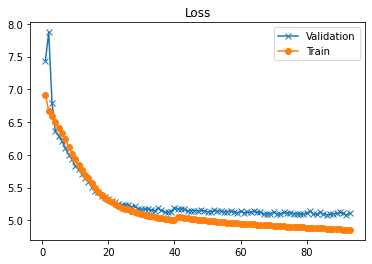

smallest val loss: (92, 5.0811315)
Current Lr:  0.00039683245

Time taken for this epoch: 39.06 secs

Epoch 94 Batch 0 Loss 4.5020
Epoch 94 Batch 150 Loss 4.7956
Epoch 94 Batch 300 Loss 4.8117
Epoch 94 Batch 450 Loss 4.8278
Epoch 94 Batch 600 Loss 4.8390
Epoch 94 Batch 750 Loss 4.8502


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.100952625274658 

* Train Loss 4.8523


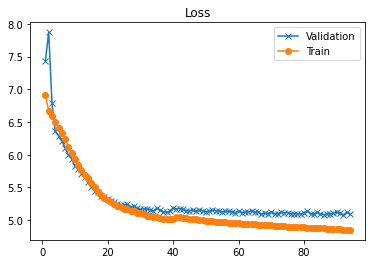

smallest val loss: (92, 5.0811315)
Current Lr:  0.00039290817

Time taken for this epoch: 38.86 secs

Epoch 95 Batch 0 Loss 5.0106
Epoch 95 Batch 150 Loss 4.7965
Epoch 95 Batch 300 Loss 4.8209
Epoch 95 Batch 450 Loss 4.8285
Epoch 95 Batch 600 Loss 4.8391
Epoch 95 Batch 750 Loss 4.8471


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.116915225982666 

* Train Loss 4.8489


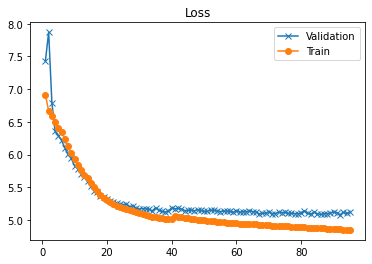

smallest val loss: (92, 5.0811315)
Current Lr:  0.00038902278

Time taken for this epoch: 38.85 secs

Epoch 96 Batch 0 Loss 4.5924
Epoch 96 Batch 150 Loss 4.7976
Epoch 96 Batch 300 Loss 4.8213
Epoch 96 Batch 450 Loss 4.8204
Epoch 96 Batch 600 Loss 4.8316
Epoch 96 Batch 750 Loss 4.8432


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.09736967086792 

* Train Loss 4.8453


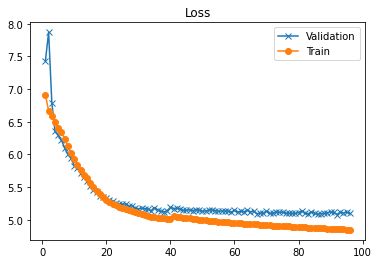

smallest val loss: (92, 5.0811315)
Current Lr:  0.00038517575

Time taken for this epoch: 39.68 secs

Epoch 97 Batch 0 Loss 5.0528
Epoch 97 Batch 150 Loss 4.7956
Epoch 97 Batch 300 Loss 4.8053
Epoch 97 Batch 450 Loss 4.8248
Epoch 97 Batch 600 Loss 4.8317
Epoch 97 Batch 750 Loss 4.8431


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.108114242553711 

* Train Loss 4.8429


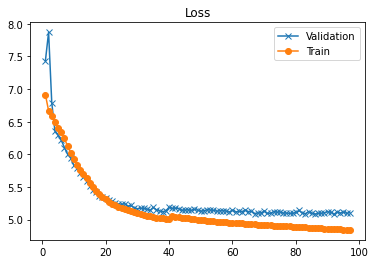

smallest val loss: (92, 5.0811315)
Current Lr:  0.00038136684

Time taken for this epoch: 38.97 secs

Epoch 98 Batch 0 Loss 4.7695
Epoch 98 Batch 150 Loss 4.7898
Epoch 98 Batch 300 Loss 4.8098
Epoch 98 Batch 450 Loss 4.8167
Epoch 98 Batch 600 Loss 4.8301
Epoch 98 Batch 750 Loss 4.8416


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101177215576172 

* Train Loss 4.8425


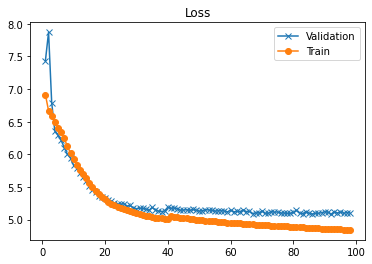

smallest val loss: (92, 5.0811315)
Current Lr:  0.00037759557

Time taken for this epoch: 39.01 secs

Epoch 99 Batch 0 Loss 4.6495
Epoch 99 Batch 150 Loss 4.7986
Epoch 99 Batch 300 Loss 4.8074
Epoch 99 Batch 450 Loss 4.8172
Epoch 99 Batch 600 Loss 4.8282
Epoch 99 Batch 750 Loss 4.8376


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.112104892730713 

* Train Loss 4.8400


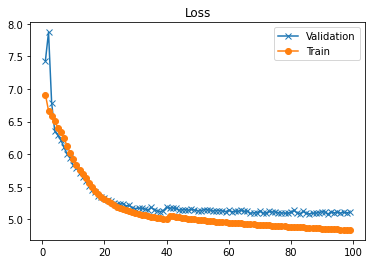

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003738616

Time taken for this epoch: 39.81 secs

Epoch 100 Batch 0 Loss 4.8193
Epoch 100 Batch 150 Loss 4.7866
Epoch 100 Batch 300 Loss 4.8074
Epoch 100 Batch 450 Loss 4.8156
Epoch 100 Batch 600 Loss 4.8235
Epoch 100 Batch 750 Loss 4.8364


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.093082427978516 

* Train Loss 4.8377


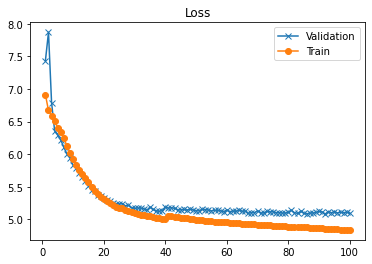

smallest val loss: (92, 5.0811315)
Current Lr:  0.00037016446

Time taken for this epoch: 39.23 secs

Epoch 101 Batch 0 Loss 4.6044
Epoch 101 Batch 150 Loss 4.7785
Epoch 101 Batch 300 Loss 4.7931
Epoch 101 Batch 450 Loss 4.8070
Epoch 101 Batch 600 Loss 4.8202
Epoch 101 Batch 750 Loss 4.8320


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101296424865723 

* Train Loss 4.8340


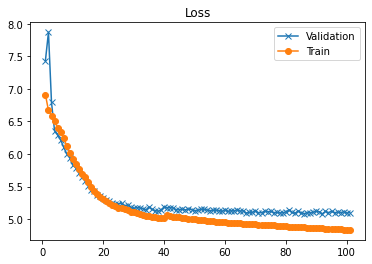

smallest val loss: (92, 5.0811315)
Current Lr:  0.00036650398

Time taken for this epoch: 39.10 secs

Epoch 102 Batch 0 Loss 4.6281
Epoch 102 Batch 150 Loss 4.7923
Epoch 102 Batch 300 Loss 4.8036
Epoch 102 Batch 450 Loss 4.8122
Epoch 102 Batch 600 Loss 4.8217
Epoch 102 Batch 750 Loss 4.8311


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101653099060059 

* Train Loss 4.8314


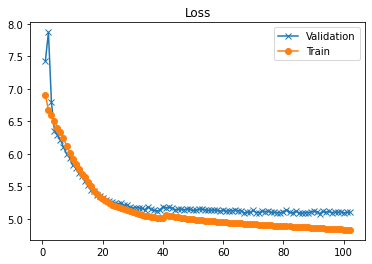

smallest val loss: (92, 5.0811315)
Current Lr:  0.00036287968

Time taken for this epoch: 38.83 secs

Epoch 103 Batch 0 Loss 4.7569
Epoch 103 Batch 150 Loss 4.7766
Epoch 103 Batch 300 Loss 4.7892
Epoch 103 Batch 450 Loss 4.8040
Epoch 103 Batch 600 Loss 4.8155
Epoch 103 Batch 750 Loss 4.8271


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.095821857452393 

* Train Loss 4.8291


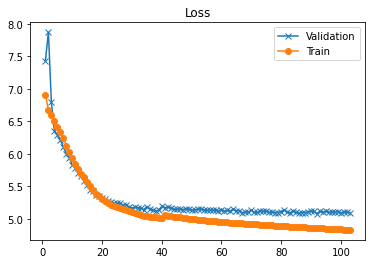

smallest val loss: (92, 5.0811315)
Current Lr:  0.00035929127

Time taken for this epoch: 39.03 secs

Epoch 104 Batch 0 Loss 4.8574
Epoch 104 Batch 150 Loss 4.7874
Epoch 104 Batch 300 Loss 4.8006
Epoch 104 Batch 450 Loss 4.8093
Epoch 104 Batch 600 Loss 4.8143
Epoch 104 Batch 750 Loss 4.8255


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.118453025817871 

* Train Loss 4.8266


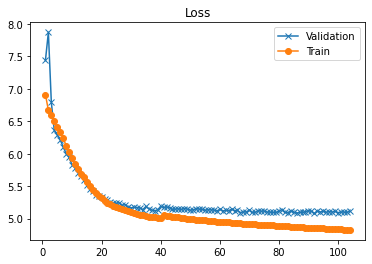

smallest val loss: (92, 5.0811315)
Current Lr:  0.00035573827

Time taken for this epoch: 38.98 secs

Epoch 105 Batch 0 Loss 4.6078
Epoch 105 Batch 150 Loss 4.7738
Epoch 105 Batch 300 Loss 4.7947
Epoch 105 Batch 450 Loss 4.8043
Epoch 105 Batch 600 Loss 4.8133
Epoch 105 Batch 750 Loss 4.8230


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.098272323608398 

* Train Loss 4.8244


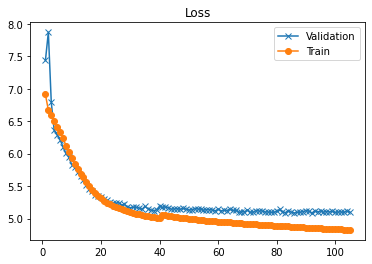

smallest val loss: (92, 5.0811315)
Current Lr:  0.00035222038

Time taken for this epoch: 38.98 secs

Epoch 106 Batch 0 Loss 4.6300
Epoch 106 Batch 150 Loss 4.7748
Epoch 106 Batch 300 Loss 4.7857
Epoch 106 Batch 450 Loss 4.8013
Epoch 106 Batch 600 Loss 4.8119
Epoch 106 Batch 750 Loss 4.8220


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.097011089324951 

* Train Loss 4.8215


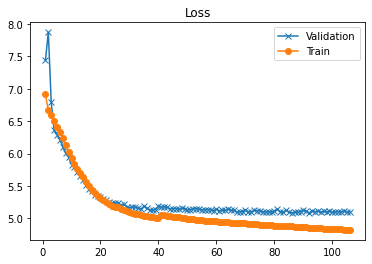

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003487373

Time taken for this epoch: 38.95 secs

Epoch 107 Batch 0 Loss 4.7214
Epoch 107 Batch 150 Loss 4.7772
Epoch 107 Batch 300 Loss 4.7835
Epoch 107 Batch 450 Loss 4.7942
Epoch 107 Batch 600 Loss 4.8041
Epoch 107 Batch 750 Loss 4.8167


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.087262153625488 

* Train Loss 4.8192


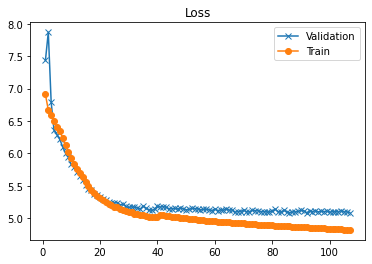

smallest val loss: (92, 5.0811315)
Current Lr:  0.00034528872

Time taken for this epoch: 39.62 secs

Epoch 108 Batch 0 Loss 4.5578
Epoch 108 Batch 150 Loss 4.7635
Epoch 108 Batch 300 Loss 4.7886
Epoch 108 Batch 450 Loss 4.7970
Epoch 108 Batch 600 Loss 4.8048
Epoch 108 Batch 750 Loss 4.8154


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.1155195236206055 

* Train Loss 4.8164


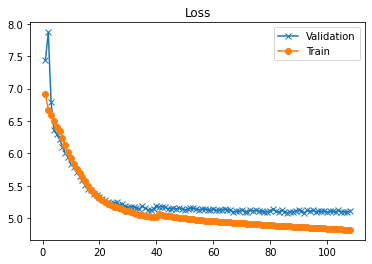

smallest val loss: (92, 5.0811315)
Current Lr:  0.00034187423

Time taken for this epoch: 38.81 secs

Epoch 109 Batch 0 Loss 4.8306
Epoch 109 Batch 150 Loss 4.7595
Epoch 109 Batch 300 Loss 4.7829
Epoch 109 Batch 450 Loss 4.7968
Epoch 109 Batch 600 Loss 4.8026
Epoch 109 Batch 750 Loss 4.8154


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.1214423179626465 

* Train Loss 4.8159


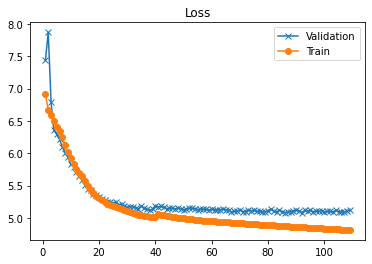

smallest val loss: (92, 5.0811315)
Current Lr:  0.00033849347

Time taken for this epoch: 39.14 secs

Epoch 110 Batch 0 Loss 4.7362
Epoch 110 Batch 150 Loss 4.7583
Epoch 110 Batch 300 Loss 4.7797
Epoch 110 Batch 450 Loss 4.7900
Epoch 110 Batch 600 Loss 4.8018
Epoch 110 Batch 750 Loss 4.8106


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.097221851348877 

* Train Loss 4.8127


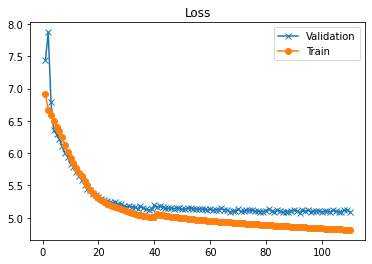

smallest val loss: (92, 5.0811315)
Current Lr:  0.00033514618

Time taken for this epoch: 38.93 secs

Epoch 111 Batch 0 Loss 4.9128
Epoch 111 Batch 150 Loss 4.7705
Epoch 111 Batch 300 Loss 4.7802
Epoch 111 Batch 450 Loss 4.7898
Epoch 111 Batch 600 Loss 4.8014
Epoch 111 Batch 750 Loss 4.8095


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.088860511779785 

* Train Loss 4.8120


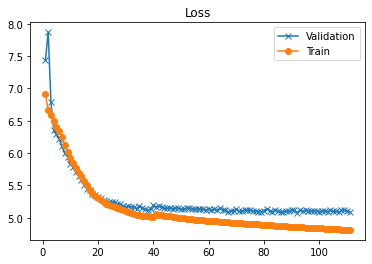

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003318319

Time taken for this epoch: 38.90 secs

Epoch 112 Batch 0 Loss 4.4432
Epoch 112 Batch 150 Loss 4.7765
Epoch 112 Batch 300 Loss 4.7900
Epoch 112 Batch 450 Loss 4.7960
Epoch 112 Batch 600 Loss 4.7997
Epoch 112 Batch 750 Loss 4.8072


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.110922813415527 

* Train Loss 4.8076


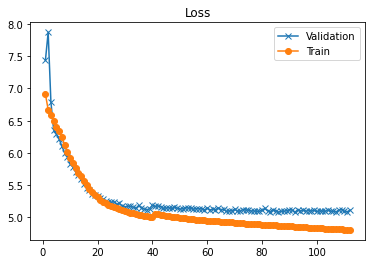

smallest val loss: (92, 5.0811315)
Current Lr:  0.00032855044

Time taken for this epoch: 39.03 secs

Epoch 113 Batch 0 Loss 4.8412
Epoch 113 Batch 150 Loss 4.7646
Epoch 113 Batch 300 Loss 4.7779
Epoch 113 Batch 450 Loss 4.7900
Epoch 113 Batch 600 Loss 4.7980
Epoch 113 Batch 750 Loss 4.8074


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.083333969116211 

* Train Loss 4.8084


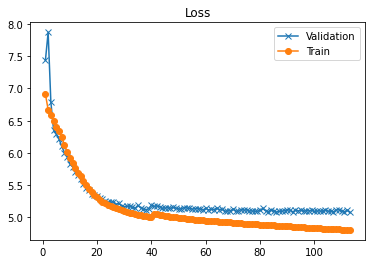

smallest val loss: (92, 5.0811315)
Current Lr:  0.00032530155

Time taken for this epoch: 38.86 secs

Epoch 114 Batch 0 Loss 4.8322
Epoch 114 Batch 150 Loss 4.7616
Epoch 114 Batch 300 Loss 4.7714
Epoch 114 Batch 450 Loss 4.7783
Epoch 114 Batch 600 Loss 4.7922
Epoch 114 Batch 750 Loss 4.8028


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.122654914855957 

* Train Loss 4.8052


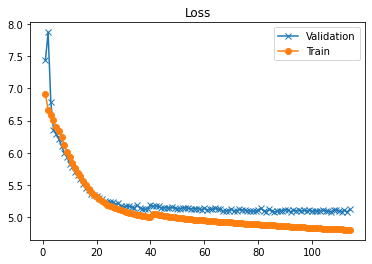

smallest val loss: (92, 5.0811315)
Current Lr:  0.00032208467

Time taken for this epoch: 38.95 secs

Epoch 115 Batch 0 Loss 4.6766
Epoch 115 Batch 150 Loss 4.7420
Epoch 115 Batch 300 Loss 4.7699
Epoch 115 Batch 450 Loss 4.7797
Epoch 115 Batch 600 Loss 4.7905
Epoch 115 Batch 750 Loss 4.8028


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.114007949829102 

* Train Loss 4.8047


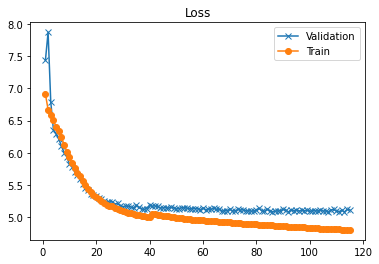

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003188996

Time taken for this epoch: 39.71 secs

Epoch 116 Batch 0 Loss 4.4362
Epoch 116 Batch 150 Loss 4.7327
Epoch 116 Batch 300 Loss 4.7625
Epoch 116 Batch 450 Loss 4.7778
Epoch 116 Batch 600 Loss 4.7916
Epoch 116 Batch 750 Loss 4.7998


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.108634948730469 

* Train Loss 4.8019


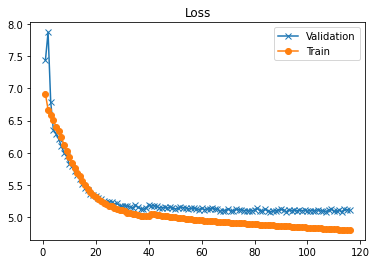

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003157461

Time taken for this epoch: 39.04 secs

Epoch 117 Batch 0 Loss 4.8018
Epoch 117 Batch 150 Loss 4.7497
Epoch 117 Batch 300 Loss 4.7660
Epoch 117 Batch 450 Loss 4.7846
Epoch 117 Batch 600 Loss 4.7892
Epoch 117 Batch 750 Loss 4.7977


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.094960689544678 

* Train Loss 4.7994


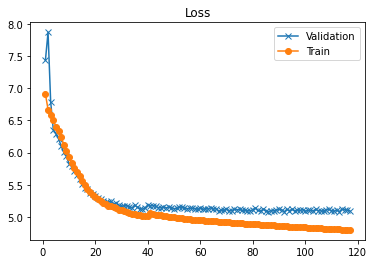

smallest val loss: (92, 5.0811315)
Current Lr:  0.00031262363

Time taken for this epoch: 39.73 secs

Epoch 118 Batch 0 Loss 4.8692
Epoch 118 Batch 150 Loss 4.7493
Epoch 118 Batch 300 Loss 4.7635
Epoch 118 Batch 450 Loss 4.7799
Epoch 118 Batch 600 Loss 4.7894
Epoch 118 Batch 750 Loss 4.7960


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101351261138916 

* Train Loss 4.7979


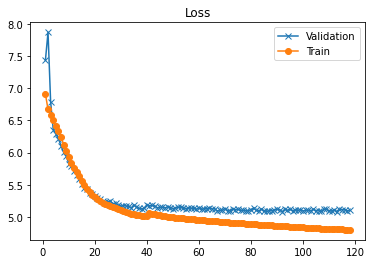

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003095322

Time taken for this epoch: 38.97 secs

Epoch 119 Batch 0 Loss 4.6107
Epoch 119 Batch 150 Loss 4.7433
Epoch 119 Batch 300 Loss 4.7547
Epoch 119 Batch 450 Loss 4.7666
Epoch 119 Batch 600 Loss 4.7823
Epoch 119 Batch 750 Loss 4.7953


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.0845818519592285 

* Train Loss 4.7961


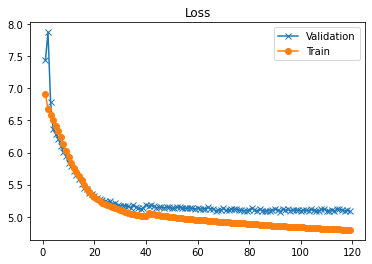

smallest val loss: (92, 5.0811315)
Current Lr:  0.0003064713

Time taken for this epoch: 38.84 secs

Epoch 120 Batch 0 Loss 4.6558
Epoch 120 Batch 150 Loss 4.7479
Epoch 120 Batch 300 Loss 4.7615
Epoch 120 Batch 450 Loss 4.7730
Epoch 120 Batch 600 Loss 4.7863
Epoch 120 Batch 750 Loss 4.7932


<UNK> <UNK> <UNK> in <UNK> <UNK>
<UNK> <UNK> <UNK> in <UNK> <UNK>
<UNK> <UNK> <UNK> in <UNK> <UNK>
<UNK> <UNK> <UNK> in <UNK> <UNK>


validation started ...

* Validation loss: 5.0769524574279785 

* Train Loss 4.7953


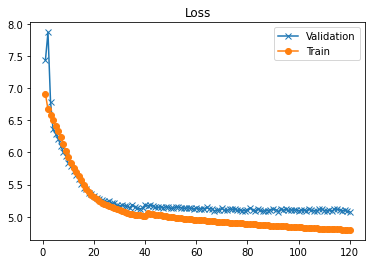

smallest val loss: (120, 5.0769525)
Current Lr:  0.0003034406

Time taken for this epoch: 39.84 secs

Epoch 121 Batch 0 Loss 4.6608
Epoch 121 Batch 150 Loss 4.7266
Epoch 121 Batch 300 Loss 4.7569
Epoch 121 Batch 450 Loss 4.7664
Epoch 121 Batch 600 Loss 4.7753
Epoch 121 Batch 750 Loss 4.7879


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.1022467613220215 

* Train Loss 4.7909


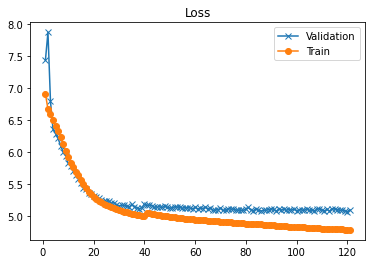

smallest val loss: (120, 5.0769525)
Current Lr:  0.00030043992

Time taken for this epoch: 38.93 secs

Epoch 122 Batch 0 Loss 4.8124
Epoch 122 Batch 150 Loss 4.7462
Epoch 122 Batch 300 Loss 4.7559
Epoch 122 Batch 450 Loss 4.7649
Epoch 122 Batch 600 Loss 4.7770
Epoch 122 Batch 750 Loss 4.7885


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101709365844727 

* Train Loss 4.7895


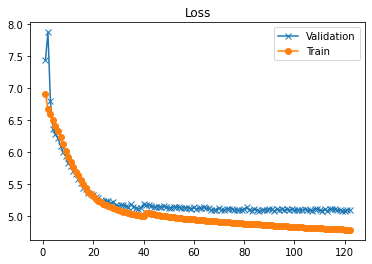

smallest val loss: (120, 5.0769525)
Current Lr:  0.00029746894

Time taken for this epoch: 38.98 secs

Epoch 123 Batch 0 Loss 4.8335
Epoch 123 Batch 150 Loss 4.7417
Epoch 123 Batch 300 Loss 4.7549
Epoch 123 Batch 450 Loss 4.7701
Epoch 123 Batch 600 Loss 4.7774
Epoch 123 Batch 750 Loss 4.7861


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.111276626586914 

* Train Loss 4.7873


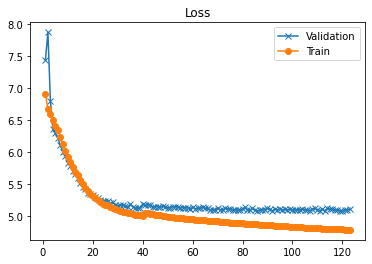

smallest val loss: (120, 5.0769525)
Current Lr:  0.00029452733

Time taken for this epoch: 38.88 secs

Epoch 124 Batch 0 Loss 4.5769
Epoch 124 Batch 150 Loss 4.7354
Epoch 124 Batch 300 Loss 4.7480
Epoch 124 Batch 450 Loss 4.7612
Epoch 124 Batch 600 Loss 4.7734
Epoch 124 Batch 750 Loss 4.7863


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.082592010498047 

* Train Loss 4.7875


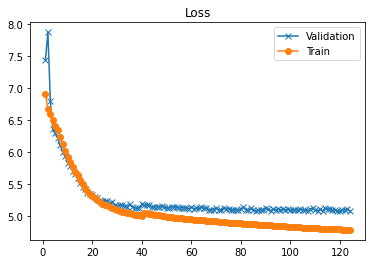

smallest val loss: (120, 5.0769525)
Current Lr:  0.00029161474

Time taken for this epoch: 39.06 secs

Epoch 125 Batch 0 Loss 4.7107
Epoch 125 Batch 150 Loss 4.7374
Epoch 125 Batch 300 Loss 4.7463
Epoch 125 Batch 450 Loss 4.7590
Epoch 125 Batch 600 Loss 4.7705
Epoch 125 Batch 750 Loss 4.7827


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.098944187164307 

* Train Loss 4.7845


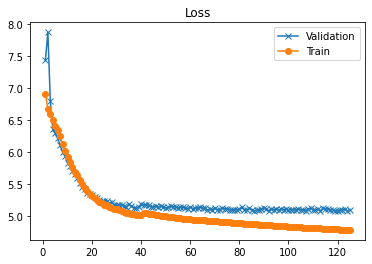

smallest val loss: (120, 5.0769525)
Current Lr:  0.00028873104

Time taken for this epoch: 39.03 secs

Epoch 126 Batch 0 Loss 4.5525
Epoch 126 Batch 150 Loss 4.7253
Epoch 126 Batch 300 Loss 4.7391
Epoch 126 Batch 450 Loss 4.7547
Epoch 126 Batch 600 Loss 4.7692
Epoch 126 Batch 750 Loss 4.7787


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.091678619384766 

* Train Loss 4.7807


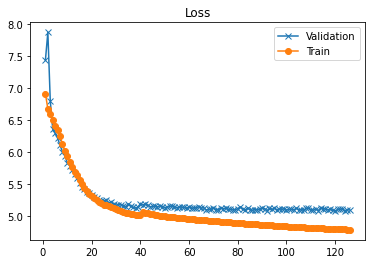

smallest val loss: (120, 5.0769525)
Current Lr:  0.00028587578

Time taken for this epoch: 38.90 secs

Epoch 127 Batch 0 Loss 4.7871
Epoch 127 Batch 150 Loss 4.7284
Epoch 127 Batch 300 Loss 4.7412
Epoch 127 Batch 450 Loss 4.7619
Epoch 127 Batch 600 Loss 4.7700
Epoch 127 Batch 750 Loss 4.7827


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.130444526672363 

* Train Loss 4.7829


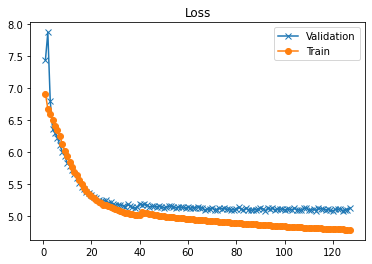

smallest val loss: (120, 5.0769525)
Current Lr:  0.00028304878

Time taken for this epoch: 38.87 secs

Epoch 128 Batch 0 Loss 4.6725
Epoch 128 Batch 150 Loss 4.7308
Epoch 128 Batch 300 Loss 4.7466
Epoch 128 Batch 450 Loss 4.7594
Epoch 128 Batch 600 Loss 4.7687
Epoch 128 Batch 750 Loss 4.7768


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.087592601776123 

* Train Loss 4.7780


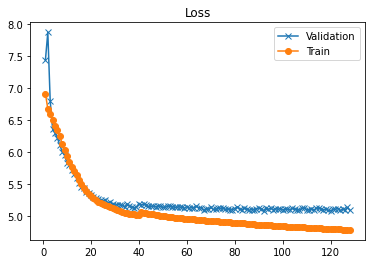

smallest val loss: (120, 5.0769525)
Current Lr:  0.0002802498

Time taken for this epoch: 38.94 secs

Epoch 129 Batch 0 Loss 4.8104
Epoch 129 Batch 150 Loss 4.7271
Epoch 129 Batch 300 Loss 4.7464
Epoch 129 Batch 450 Loss 4.7568
Epoch 129 Batch 600 Loss 4.7667
Epoch 129 Batch 750 Loss 4.7746


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.075966835021973 

* Train Loss 4.7766


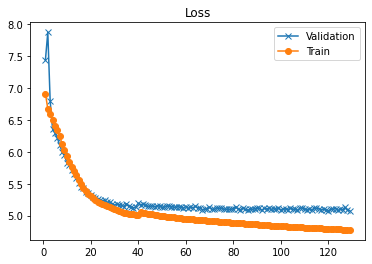

smallest val loss: (129, 5.075967)
Current Lr:  0.00027747848

Time taken for this epoch: 38.87 secs

Epoch 130 Batch 0 Loss 4.6584
Epoch 130 Batch 150 Loss 4.7234
Epoch 130 Batch 300 Loss 4.7392
Epoch 130 Batch 450 Loss 4.7559
Epoch 130 Batch 600 Loss 4.7632
Epoch 130 Batch 750 Loss 4.7754


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.078345775604248 

* Train Loss 4.7764


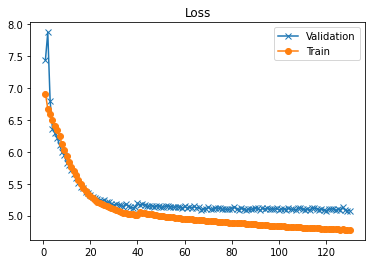

smallest val loss: (129, 5.075967)
Current Lr:  0.00027473446

Time taken for this epoch: 38.93 secs

Epoch 131 Batch 0 Loss 4.7175
Epoch 131 Batch 150 Loss 4.7093
Epoch 131 Batch 300 Loss 4.7390
Epoch 131 Batch 450 Loss 4.7510
Epoch 131 Batch 600 Loss 4.7625
Epoch 131 Batch 750 Loss 4.7718


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.10556697845459 

* Train Loss 4.7741


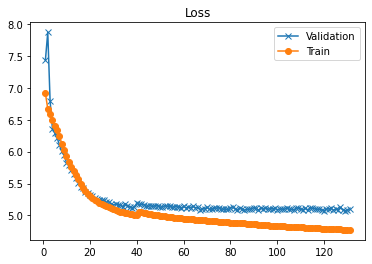

smallest val loss: (129, 5.075967)
Current Lr:  0.00027201767

Time taken for this epoch: 39.00 secs

Epoch 132 Batch 0 Loss 4.6011
Epoch 132 Batch 150 Loss 4.7400
Epoch 132 Batch 300 Loss 4.7440
Epoch 132 Batch 450 Loss 4.7455
Epoch 132 Batch 600 Loss 4.7566
Epoch 132 Batch 750 Loss 4.7716


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.101849555969238 

* Train Loss 4.7729


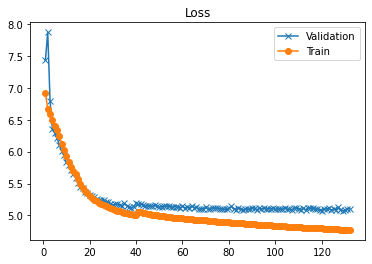

smallest val loss: (129, 5.075967)
Current Lr:  0.00026932772

Time taken for this epoch: 38.98 secs

Epoch 133 Batch 0 Loss 4.7090
Epoch 133 Batch 150 Loss 4.7162
Epoch 133 Batch 300 Loss 4.7337
Epoch 133 Batch 450 Loss 4.7496
Epoch 133 Batch 600 Loss 4.7601
Epoch 133 Batch 750 Loss 4.7681


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.109615802764893 

* Train Loss 4.7702


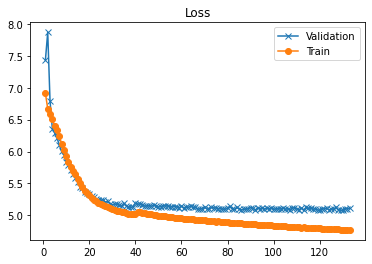

smallest val loss: (129, 5.075967)
Current Lr:  0.00026666443

Time taken for this epoch: 39.03 secs

Epoch 134 Batch 0 Loss 4.6620
Epoch 134 Batch 150 Loss 4.7198
Epoch 134 Batch 300 Loss 4.7384
Epoch 134 Batch 450 Loss 4.7469
Epoch 134 Batch 600 Loss 4.7564
Epoch 134 Batch 750 Loss 4.7677


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.087450981140137 

* Train Loss 4.7681


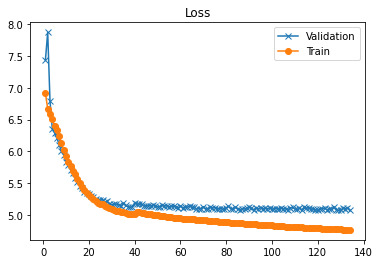

smallest val loss: (129, 5.075967)
Current Lr:  0.0002640274

Time taken for this epoch: 38.93 secs

Epoch 135 Batch 0 Loss 4.7531
Epoch 135 Batch 150 Loss 4.7119
Epoch 135 Batch 300 Loss 4.7330
Epoch 135 Batch 450 Loss 4.7404
Epoch 135 Batch 600 Loss 4.7541
Epoch 135 Batch 750 Loss 4.7645


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.103847980499268 

* Train Loss 4.7663


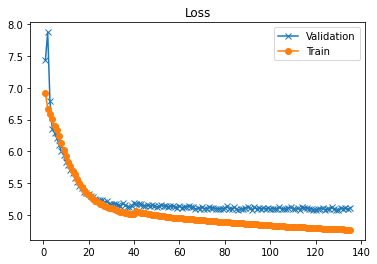

smallest val loss: (129, 5.075967)
Current Lr:  0.00026141648

Time taken for this epoch: 38.92 secs

Epoch 136 Batch 0 Loss 4.8010
Epoch 136 Batch 150 Loss 4.7226
Epoch 136 Batch 300 Loss 4.7369
Epoch 136 Batch 450 Loss 4.7443
Epoch 136 Batch 600 Loss 4.7535
Epoch 136 Batch 750 Loss 4.7623


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.095014572143555 

* Train Loss 4.7636


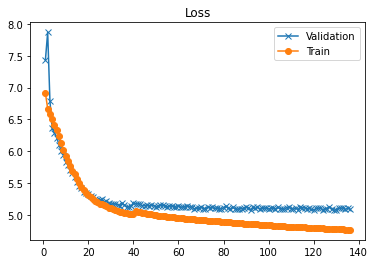

smallest val loss: (129, 5.075967)
Current Lr:  0.0002588313

Time taken for this epoch: 38.94 secs

Epoch 137 Batch 0 Loss 4.9005
Epoch 137 Batch 150 Loss 4.7227
Epoch 137 Batch 300 Loss 4.7354
Epoch 137 Batch 450 Loss 4.7393
Epoch 137 Batch 600 Loss 4.7518
Epoch 137 Batch 750 Loss 4.7595


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.087189197540283 

* Train Loss 4.7617


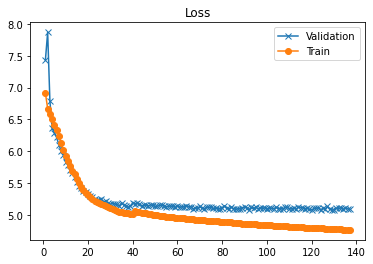

smallest val loss: (129, 5.075967)
Current Lr:  0.00025627177

Time taken for this epoch: 38.94 secs

Epoch 138 Batch 0 Loss 4.6769
Epoch 138 Batch 150 Loss 4.7266
Epoch 138 Batch 300 Loss 4.7326
Epoch 138 Batch 450 Loss 4.7407
Epoch 138 Batch 600 Loss 4.7510
Epoch 138 Batch 750 Loss 4.7608


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.084089279174805 

* Train Loss 4.7620


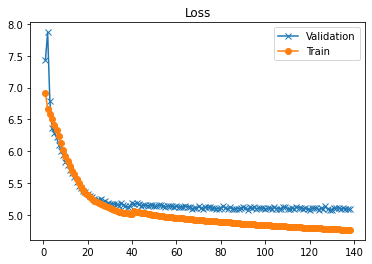

smallest val loss: (129, 5.075967)
Current Lr:  0.00025373758

Time taken for this epoch: 38.93 secs

Epoch 139 Batch 0 Loss 4.5106
Epoch 139 Batch 150 Loss 4.7088
Epoch 139 Batch 300 Loss 4.7352
Epoch 139 Batch 450 Loss 4.7429
Epoch 139 Batch 600 Loss 4.7512
Epoch 139 Batch 750 Loss 4.7600


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.09005069732666 

* Train Loss 4.7610


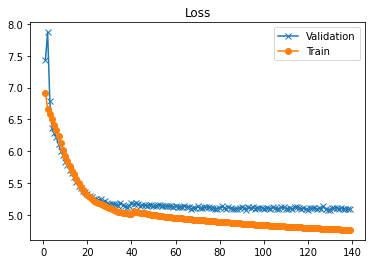

smallest val loss: (129, 5.075967)
Current Lr:  0.0002512284

Time taken for this epoch: 38.83 secs

Epoch 140 Batch 0 Loss 4.7990
Epoch 140 Batch 150 Loss 4.7166
Epoch 140 Batch 300 Loss 4.7290
Epoch 140 Batch 450 Loss 4.7385
Epoch 140 Batch 600 Loss 4.7447
Epoch 140 Batch 750 Loss 4.7567


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.075314998626709 

* Train Loss 4.7600


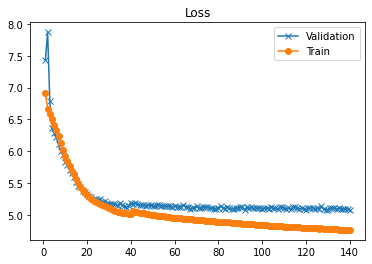

smallest val loss: (140, 5.075315)
Current Lr:  0.00024874407

Time taken for this epoch: 38.93 secs

Epoch 141 Batch 0 Loss 4.7723
Epoch 141 Batch 150 Loss 4.7183
Epoch 141 Batch 300 Loss 4.7254
Epoch 141 Batch 450 Loss 4.7330
Epoch 141 Batch 600 Loss 4.7448
Epoch 141 Batch 750 Loss 4.7558


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.072406768798828 

* Train Loss 4.7570


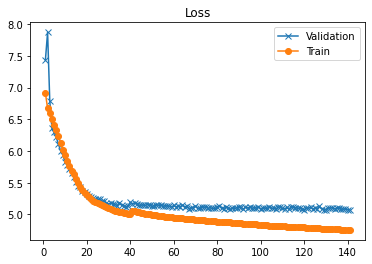

smallest val loss: (141, 5.072407)
Current Lr:  0.00024628424

Time taken for this epoch: 39.06 secs

Epoch 142 Batch 0 Loss 4.7826
Epoch 142 Batch 150 Loss 4.7169
Epoch 142 Batch 300 Loss 4.7321
Epoch 142 Batch 450 Loss 4.7415
Epoch 142 Batch 600 Loss 4.7452
Epoch 142 Batch 750 Loss 4.7546


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.093005657196045 

* Train Loss 4.7554


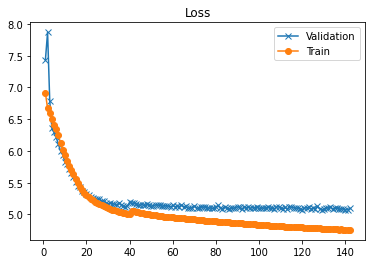

smallest val loss: (141, 5.072407)
Current Lr:  0.00024384874

Time taken for this epoch: 38.95 secs

Epoch 143 Batch 0 Loss 4.7449
Epoch 143 Batch 150 Loss 4.7158
Epoch 143 Batch 300 Loss 4.7264
Epoch 143 Batch 450 Loss 4.7374
Epoch 143 Batch 600 Loss 4.7437
Epoch 143 Batch 750 Loss 4.7532


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.085704803466797 

* Train Loss 4.7540


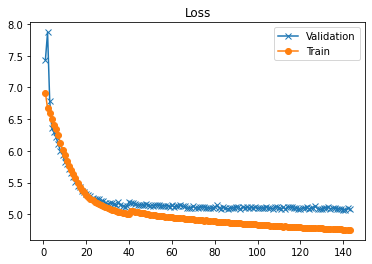

smallest val loss: (141, 5.072407)
Current Lr:  0.00024143739

Time taken for this epoch: 38.87 secs

Epoch 144 Batch 0 Loss 4.7595
Epoch 144 Batch 150 Loss 4.6962
Epoch 144 Batch 300 Loss 4.7200
Epoch 144 Batch 450 Loss 4.7297
Epoch 144 Batch 600 Loss 4.7378
Epoch 144 Batch 750 Loss 4.7483


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.0842695236206055 

* Train Loss 4.7520


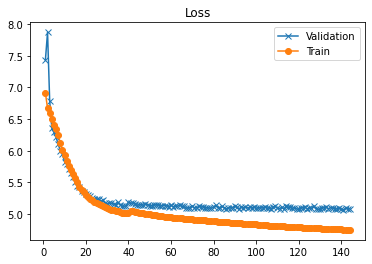

smallest val loss: (141, 5.072407)
Current Lr:  0.00023904983

Time taken for this epoch: 38.96 secs

Epoch 145 Batch 0 Loss 4.5238
Epoch 145 Batch 150 Loss 4.7120
Epoch 145 Batch 300 Loss 4.7294
Epoch 145 Batch 450 Loss 4.7312
Epoch 145 Batch 600 Loss 4.7403
Epoch 145 Batch 750 Loss 4.7496


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.096005916595459 

* Train Loss 4.7509


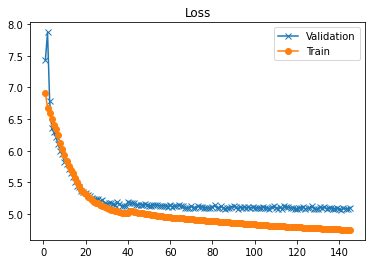

smallest val loss: (141, 5.072407)
Current Lr:  0.00023668591

Time taken for this epoch: 38.97 secs

Epoch 146 Batch 0 Loss 4.6772
Epoch 146 Batch 150 Loss 4.6952
Epoch 146 Batch 300 Loss 4.7126
Epoch 146 Batch 450 Loss 4.7270
Epoch 146 Batch 600 Loss 4.7377
Epoch 146 Batch 750 Loss 4.7473


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.073331832885742 

* Train Loss 4.7480


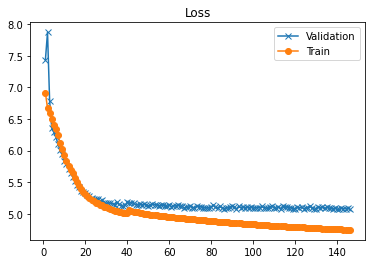

smallest val loss: (141, 5.072407)
Current Lr:  0.00023434535

Time taken for this epoch: 39.21 secs

Epoch 147 Batch 0 Loss 4.7409
Epoch 147 Batch 150 Loss 4.7017
Epoch 147 Batch 300 Loss 4.7168
Epoch 147 Batch 450 Loss 4.7290
Epoch 147 Batch 600 Loss 4.7401
Epoch 147 Batch 750 Loss 4.7472


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.082943439483643 

* Train Loss 4.7475


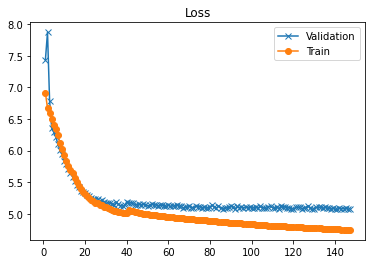

smallest val loss: (141, 5.072407)
Current Lr:  0.00023202795

Time taken for this epoch: 38.99 secs

Epoch 148 Batch 0 Loss 4.6927
Epoch 148 Batch 150 Loss 4.7039
Epoch 148 Batch 300 Loss 4.7119
Epoch 148 Batch 450 Loss 4.7295
Epoch 148 Batch 600 Loss 4.7358
Epoch 148 Batch 750 Loss 4.7453


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.084588527679443 

* Train Loss 4.7468


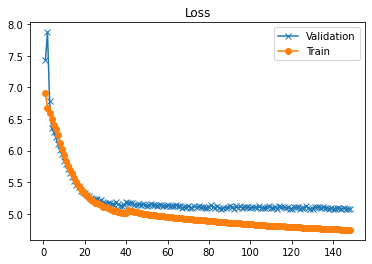

smallest val loss: (141, 5.072407)
Current Lr:  0.00022973346

Time taken for this epoch: 39.01 secs

Epoch 149 Batch 0 Loss 4.7892
Epoch 149 Batch 150 Loss 4.6874
Epoch 149 Batch 300 Loss 4.7066
Epoch 149 Batch 450 Loss 4.7219
Epoch 149 Batch 600 Loss 4.7313
Epoch 149 Batch 750 Loss 4.7433


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.087775707244873 

* Train Loss 4.7445


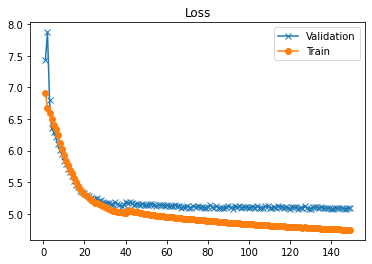

smallest val loss: (141, 5.072407)
Current Lr:  0.00022746163

Time taken for this epoch: 39.06 secs

Epoch 150 Batch 0 Loss 4.5215
Epoch 150 Batch 150 Loss 4.7035
Epoch 150 Batch 300 Loss 4.7184
Epoch 150 Batch 450 Loss 4.7268
Epoch 150 Batch 600 Loss 4.7345
Epoch 150 Batch 750 Loss 4.7397


<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>


validation started ...

* Validation loss: 5.084837436676025 

* Train Loss 4.7418


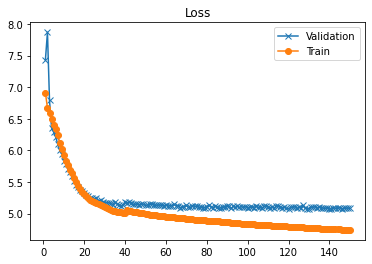

smallest val loss: (141, 5.072407)
Current Lr:  0.00022521231

Time taken for this epoch: 38.90 secs



In [ ]:
x = PrettyTable()
x.field_names = ["Param", "value"]
for key, value in params.items():
  x.add_row([key, value])

print(x)
print('#'*50)
print("\n")
EPOCHS = 150
for epoch in range(ep,EPOCHS+1):
    ep = epoch

    start = time.time()
    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    print("\n")
    data = print_summarise(longreview_val['long'])
    for d in data:
      print(d)
    print("\n")
    
    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))
    
    
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\n Saving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    hist(history)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*50)

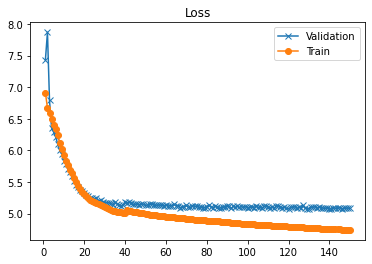

smallest val loss: (141, 5.072407)


{'d_model': 50,
 'd_out_rate': 0.1,
 'dff': 512,
 'init_lr': 0.001,
 'lmbda_l2': 0.1,
 'num_heads': 5,
 'num_layers': 6}

In [ ]:
hist(history)
params

In [ ]:
# transformer.load_weights("/content/drive/MyDrive/Machine_Learning/Project/checkpoints4/ckpt-14.index")

In [ ]:
# print(clean_words(longreview_val['long'][i2]))
# print(summarize(clean_words(longreview_val['long'][i2])))

In [ ]:
!pip install sumeval
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 734 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
from sumeval.metrics.rouge import RougeCalculator

def eval_rouges(refrence_summary, model_summary):
    rouge = RougeCalculator(stopwords=True, lang="en")

    rouge_1 = rouge.rouge_n(
                summary=model_summary,
                references=refrence_summary,
                n=1)

    rouge_2 = rouge.rouge_n(
                summary=model_summary,
                references=[refrence_summary],
                n=2)
    
    rouge_l = rouge.rouge_l(
                summary=model_summary,
                references=[refrence_summary])
    
    # You need spaCy to calculate ROUGE-BE
    
    rouge_be = rouge.rouge_be(
                summary=model_summary,
                references=[refrence_summary])


    return rouge_1, rouge_2,rouge_l,rouge_be


In [ ]:
from xml.etree.ElementTree import Element, SubElement, Comment
top = Element('Sid')

comment = Comment('Generated by Sid')
top.append(comment)


In [ ]:
from functools import reduce


In [ ]:
rouge_1_arr  = []
rouge_2_arr  = []
rouge_L_arr  = []
rouge_be_arr = []
i = 0 
for summ, longr in zip(summaries_val['short'], longreview_val['long']):
  i = i  + 1
  print(i)
  print(" ")
  example = SubElement(top, 'example')
  rouge_1, rouge_2,rouge_L,rouge_be = eval_rouges(clean_words(summ),summarize(clean_words(longr)))
  
  eval_element = SubElement(example, 'eval')
  ROUGE_1_element  = SubElement(eval_element, 'ROUGE_1' , {'score':str(rouge_1)})
  ROUGE_2_element  = SubElement(eval_element, 'ROUGE_2' , {'score':str(rouge_2)})
  ROUGE_L_element  = SubElement(eval_element, 'ROUGE_l' , {'score':str(rouge_L)})
  ROUGE_be_element  = SubElement(eval_element,'ROUGE_be', {'score':str(rouge_be)})

  rouge_1_arr.append(rouge_1) 
  rouge_2_arr.append(rouge_2) 
  rouge_L_arr.append(rouge_L) 
  rouge_be_arr.append(rouge_be) 
  
  


rouge_1_avg = str(reduce(lambda x, y: x + y,  rouge_1_arr) / len(rouge_1_arr))
rouge_2_avg = str(reduce(lambda x, y: x + y,  rouge_2_arr) / len(rouge_2_arr))
rouge_3_avg = str(reduce(lambda x, y: x + y,  rouge_L_arr) / len(rouge_L_arr))
rouge_4_avg = str(reduce(lambda x, y: x + y, rouge_be_arr) / len(rouge_be_arr))

print(rouge_1_avg)
print(rouge_2_avg)
print(rouge_3_avg)
print(rouge_4_avg)

In [ ]:
print(clean_words(summaries_val['short'][6]))
print()
print(summarize(clean_words(longreview_val['long'][6])))